In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_11_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              11                   1           AC            SVE   
1              11                   1           AC            SVE   
2              11                   1           AC            SVE   
3              11                   1           AC            SVE   
4              11                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo FechaMovimiento  \
0   VENTA COMPUTARIZADA          18110999                  0      2018-11-06   
1   VENTA COMPUTARIZADA          18110996                  0      2018-11-06   
2   VENTA COMPUTARIZADA          18110995                  0      2018-11-06   
3   VENTA COMPUTARIZADA          18110992                  0      2018-11-06   
4   VENTA COMPUTARIZADA          18110978                  0      2018-11-06   

             NombreProducto UnidadMedida  CantidadSalida  PesoSalida  \
0  POLLO SIN MENUDENCIA H-C           KG          0.0000      1.2415   
1                   CORAZON           KG          0.0000      0.9274   
2  POLLO SIN MENUDENCIA H-C           KG          0.0000     23.6785   
3                   CORAZON           KG          0.0000      0.8927   
4                   CORAZON           KG          0.0000      2.6700   

   MontoBase  PrecioUnitario  CostoUnitario  MontoReferencia NombreGrupo  
0    15.1300         10.8580        10.8580           2.1743    FAENEADO  
1    11.5700         11.1250        11.1250           1.6625    FAENEADO  
2   288.8940         10.8580        10.8580          41.5078    FAENEADO  
3    11.1250         11.1250        11.1250           1.5984    FAENEADO  
4    33.3750         11.1250        11.1250           4.7953    FAENEADO

In [5]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [8]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] < '2023-12-01')]

# Restar los registros antes del 2021 y de noviembre del conjunto original
df_todo_hasta_nov = df_todo[(df_todo['FechaMovimiento'] >= '2021-01-01') & (df_todo['FechaMovimiento'] < '2023-11-01')]

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [9]:
print("todo                       - ", df_todo.shape)
print("desde 2021 hasta nov2023   - ", df_todo_hasta_nov.shape)
print("noviembre 2023             - ", df_noviembre.shape)

todo                       -  (279477, 4)
desde 2021 hasta nov2023   -  (170908, 4)
noviembre 2023             -  (4370, 4)


In [10]:
# df_noviembre.head()
# df_noviembre.tail()
# df_todo_hasta_nov

## EVALUACION

In [11]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [12]:
def evaluacion_metrica_todos_los_valores(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

# Creacion del objeto con los dataframes de los 3 productos


In [13]:
## Tratamos la columna 'FechaMovimiento' de ambos dataframes
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
276324  POLLO SIN MENUDENCIA H-C      2023-11-01    28.4088  2023
276277  POLLO SIN MENUDENCIA H-C      2023-11-01   178.1513  2023
276322  POLLO SIN MENUDENCIA H-C      2023-11-01    29.5925  2023
276295  POLLO SIN MENUDENCIA H-C      2023-11-01    29.5925  2023
276294  POLLO SIN MENUDENCIA H-C      2023-11-01    34.3273  2023
...                          ...             ...        ...   ...
279428  POLLO SIN MENUDENCIA H-C      2023-11-30    31.3725  2023
279413  POLLO SIN MENUDENCIA H-C      2023-11-30    28.4088  2023
279414  POLLO SIN MENUDENCIA H-C      2023-11-30    33.7399  2023
279415  POLLO SIN MENUDENCIA H-C      2023-11-30    56.8176  2023
279416  POLLO SIN MENUDENCIA H-C      2023-11-30   262.7814  2023

[4370 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

### Seleccion de los productos top 3


In [14]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo_hasta_nov.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo_hasta_nov.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Paso 3: Seleccionar los nombres de los tres primeros productos
nombres_productos_con_mas_ventas = dias_de_venta_por_producto['NombreProducto'].head(10).tolist()

# Filtrar y ordenar los productos por la suma total de MontoBase
ventas_por_producto = df.groupby('NombreProducto')['MontoBase'].sum().reset_index()
top_productos = ventas_por_producto[ventas_por_producto['NombreProducto'].isin(nombres_productos_con_mas_ventas)]
top_productos = top_productos.sort_values(by='MontoBase', ascending=False).reset_index(drop=True)

top_productos = pd.merge(top_productos, dias_de_venta_por_producto, on='NombreProducto')

# Imprimir los días de venta y el MontoBase total de cada producto
print("\nDías de venta y MontoBase total para cada producto:")
print(top_productos[['NombreProducto', 'MontoBase']])

# Seleccionar el top 3 productos en función de la suma total de MontoBase
top_3_productos = top_productos.head(3)

print("\n Posible Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

# Verificar si hay algún producto en el top 3 con menos de 750 días de venta
if top_3_productos['DiasDeVenta'].min() < 750:
    # Obtener el índice del producto con menos de 750 días de venta
    indice_producto = top_3_productos[top_3_productos['DiasDeVenta'] < 750].index[0]

    # Obtener el siguiente producto con más de 750 días de venta
    siguiente_producto = top_productos[top_productos['DiasDeVenta'] >= 750].iloc[indice_producto]

    # Reemplazar el producto en el top 3 con el siguiente producto
    top_3_productos.iloc[-1] = siguiente_producto

# Formatear la columna 'MontoBase' con 2 decimales
top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))

# Imprimir la lista final
print("\n Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'PECHUGA', 'CORAZON',
       'RABADILLA', 'CUELLO', 'HIGADO', 'MENUDENCIA',
       'SACHET MORTADELA DE POLLO 200 GRS', 'PATE GRANDE 200G'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
                      NombreProducto  DiasDeVenta
0           POLLO SIN MENUDENCIA H-C          996
1                            PECHUGA          924
2                       PIERNA MUSLO          904
3                             CUELLO          892
4                             HIGADO          791
5                         MENUDENCIA          758
6                          RABADILLA          736
7                            CORAZON          681
8                   PATE GRANDE 200G          523
9  SACHET MORTADELA DE POLLO 200 GRS          473

Días de venta y MontoBase total para cada producto:
                      NombreProducto     MontoBase
0           POLLO SIN MENUDENCIA

<ipython-input-14-566056649ac0>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))


### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [15]:
#objeto que contendra los dataframes de los top 3 productos
dfs_de_productos = {}

# Iterar sobre los productos y dividir el DataFrame
for nombre_producto in top_3_productos['NombreProducto']:
    # Crear un DataFrame para el producto actual
    product_df = df_todo_hasta_nov[df_todo_hasta_nov['NombreProducto'] == nombre_producto].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    product_df.set_index('FechaMovimiento', inplace=True)

    # Almacenar el DataFrame en el diccionario
    dfs_de_productos[nombre_producto] = product_df

In [16]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado

In [17]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].tail)
print(dfs_de_productos_sumados['PIERNA MUSLO'].tail)
# print(dfs_de_productos['POLLO SIN MENUDENCIA H-C'].head)

FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
<bound method NDFrame.tail of     FechaMovimiento            NombreProducto  year  MontoBase
0        2021-01-02  POLLO SIN MENUDENCIA H-C  2021 10510.9000
1        2021-01-03  POLLO SIN MENUDENCIA H-C  2021  4100.4080
2        2021-01-04  POLLO SIN MENUDENCIA H-C  2021  4341.8650
3        2021-01-05  POLLO SIN MENUDENCIA H-C  2021  4555.7320
4        2021-01-06  POLLO SIN MENUDENCIA H-C  2021  6008.0340
..              ...                       ...   ...        ...
991      2023-10-27  POLLO SIN MENUDENCIA H-C  2023  6026.4036
992      2023-10-28  POLLO SIN MENUDENCIA H-C  2023  5949.4542
993      2023-10-29  POLLO SIN MENUDENCIA H-C  2023   374.6544
994      2023-10-30  POLLO SIN MENUDENCIA H-C  2023 12163.1227
995      2023-10-31  POLLO SIN MENUDENCIA H-C  2023  7254.2832

[996 rows x 4 columns]>
<bound method NDFrame.tail of     FechaMovimiento NombreProducto  y

In [18]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 2023, 0, last_day_oct_2023]], columns=['NombreProducto', 'year', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['year', 'NombreProducto', 'FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")

    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)

<ipython-input-18-7c618e69a328>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-18-7c618e69a328>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-18-7c618e69a328>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:


In [19]:
print(dfs_de_productos_sumados)

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2021-01-02       POLLO SIN MENUDENCIA H-C  2021 10510.9000
2021-01-03       POLLO SIN MENUDENCIA H-C  2021  4100.4080
2021-01-04       POLLO SIN MENUDENCIA H-C  2021  4341.8650
2021-01-05       POLLO SIN MENUDENCIA H-C  2021  4555.7320
2021-01-06       POLLO SIN MENUDENCIA H-C  2021  6008.0340
...                                   ...   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  2023  6026.4036
2023-10-28       POLLO SIN MENUDENCIA H-C  2023  5949.4542
2023-10-29       POLLO SIN MENUDENCIA H-C  2023   374.6544
2023-10-30       POLLO SIN MENUDENCIA H-C  2023 12163.1227
2023-10-31       POLLO SIN MENUDENCIA H-C  2023  7254.2832

[996 rows x 3 columns], 'PIERNA MUSLO':                 NombreProducto  year  MontoBase
FechaMovimiento                                
2021-01-02        PIERNA MUSLO  2021   301.0240
2021-01-03        P

In [20]:
import copy

# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_prophet = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

    # Eliminar la columna 'year'
    product_df_prophet.drop(columns=['year'], inplace=True)

In [21]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].head)

NombreProducto     object
year                int64
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2021-01-02       POLLO SIN MENUDENCIA H-C  2021 10510.9000
2021-01-03       POLLO SIN MENUDENCIA H-C  2021  4100.4080
2021-01-04       POLLO SIN MENUDENCIA H-C  2021  4341.8650
2021-01-05       POLLO SIN MENUDENCIA H-C  2021  4555.7320
2021-01-06       POLLO SIN MENUDENCIA H-C  2021  6008.0340
...                                   ...   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  2023  6026.4036
2023-10-28       POLLO SIN MENUDENCIA H-C  2023  5949.4542
2023-10-29       POLLO SIN MENUDENCIA H-C  2023   374.6544
2023-10-30       POLLO SIN MENUDENCIA H-C  2023 12163.1227
2023-10-31       POLLO SIN MENUDENCIA H-C  2023  7254.2832

[996 rows x 3 columns]>


In [22]:
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].head)

ds                 object
NombreProducto     object
y                 float64
dtype: object
<bound method NDFrame.head of              ds            NombreProducto          y
0    2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
1    2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
2    2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
3    2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
4    2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
..          ...                       ...        ...
991  2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
992  2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
993  2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
994  2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
995  2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[996 rows x 3 columns]>


In [23]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

             ds            NombreProducto          y
0    2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
1    2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
2    2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
3    2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
4    2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
..          ...                       ...        ...
991  2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
992  2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
993  2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
994  2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
995  2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[996 rows x 3 columns]
             ds NombreProducto        y
0    2021-01-02   PIERNA MUSLO 301.0240
1    2021-01-03   PIERNA MUSLO 499.9280
2    2021-01-05   PIERNA MUSLO 306.3600
3    2021-01-06   PIERNA MUSLO 514.6480
4    2021-01-07   PIERNA MUSLO 322.5520
..          ...            ...      ...
899  2023-10-27   PIERNA MUSLO 295.3844
900  2023-10-28   PI

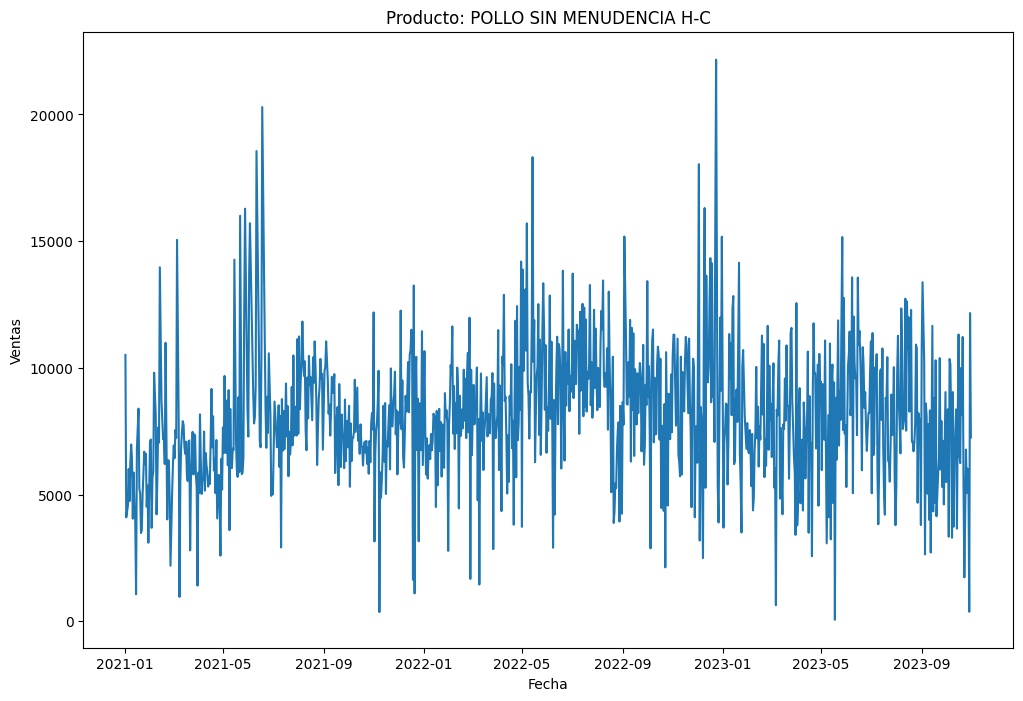

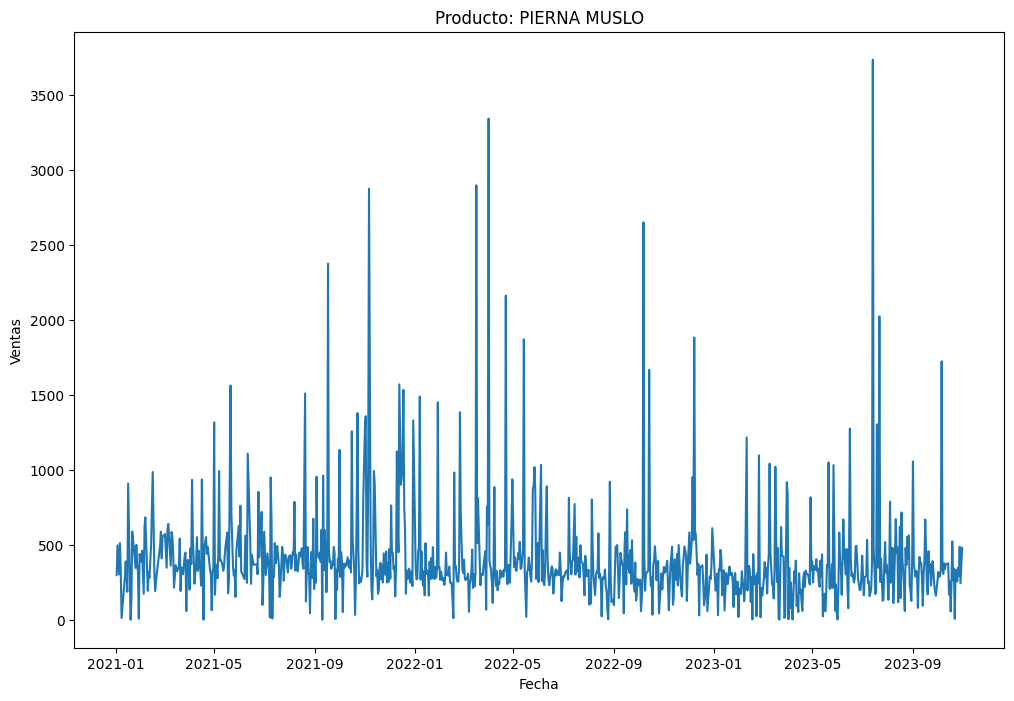

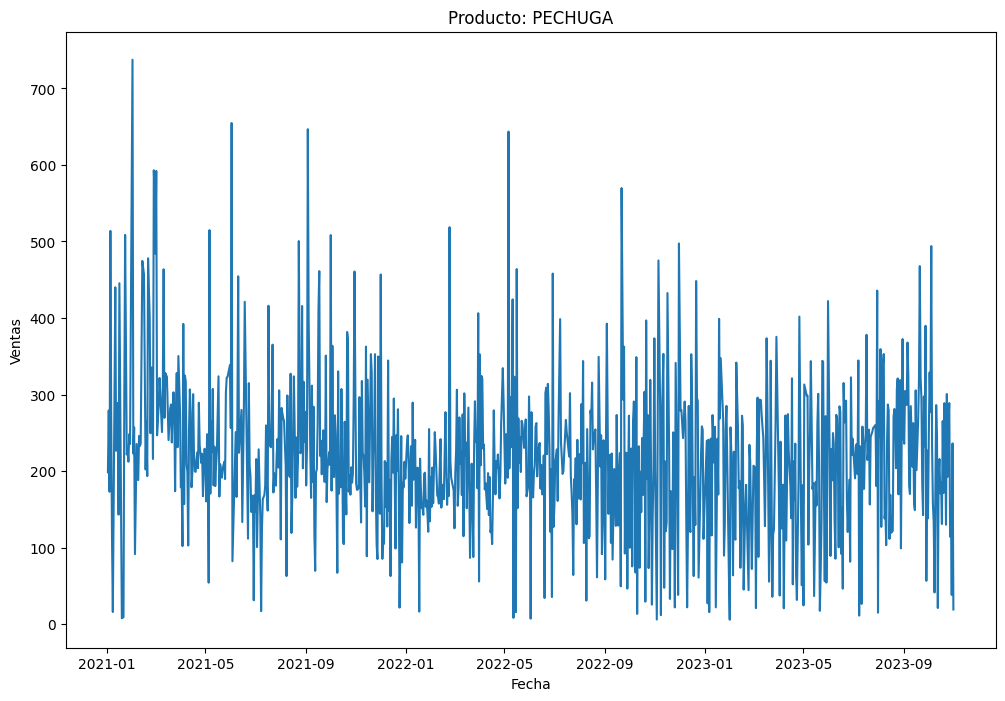

In [24]:
# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Crear una nueva figura y ejes para cada producto
    fig, ax = plt.subplots(figsize=(12, 8))

    # Crear un gráfico de líneas para cada producto
    ax.plot(product_df['ds'], product_df['y'], label=product)
    ax.set_title(f'Producto: {product}')  # Utiliza 'set_title' en lugar de 'plt.set_title'
    ax.set_xlabel('Fecha')  # Utiliza 'set_xlabel' en lugar de 'plt.set_xlabel'
    ax.set_ylabel('Ventas')  # Utiliza 'set_ylabel' en lugar de 'plt.set_ylabel'

    # Mostrar el gráfico para el producto actual
    plt.show()

In [25]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object


### clonar para LSTM y ARIMA


In [26]:
dfs_de_productos_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
 FechaMovimiento                                           
 2021-01-02       POLLO SIN MENUDENCIA H-C  2021 10510.9000
 2021-01-03       POLLO SIN MENUDENCIA H-C  2021  4100.4080
 2021-01-04       POLLO SIN MENUDENCIA H-C  2021  4341.8650
 2021-01-05       POLLO SIN MENUDENCIA H-C  2021  4555.7320
 2021-01-06       POLLO SIN MENUDENCIA H-C  2021  6008.0340
 ...                                   ...   ...        ...
 2023-10-27       POLLO SIN MENUDENCIA H-C  2023  6026.4036
 2023-10-28       POLLO SIN MENUDENCIA H-C  2023  5949.4542
 2023-10-29       POLLO SIN MENUDENCIA H-C  2023   374.6544
 2023-10-30       POLLO SIN MENUDENCIA H-C  2023 12163.1227
 2023-10-31       POLLO SIN MENUDENCIA H-C  2023  7254.2832
 
 [996 rows x 3 columns],
 'PIERNA MUSLO':                 NombreProducto  year  MontoBase
 FechaMovimiento                                
 2021-01-02        PIERNA MUSLO  2021   301.0240
 2

In [27]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_lstm = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Restablecer el índice
    product_df_lstm.reset_index(inplace=True)
    print(product_df_lstm.head)
    print(product_df_lstm.dtypes)

    # Convertir 'FechaMovimiento' a tipo de dato datetime
    product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])

    # Configurar 'FechaMovimiento' como índice
    product_df_lstm.set_index('FechaMovimiento', inplace=True)
    print(product_df_lstm.dtypes)

    # Preprocesamiento de fechas utilizando el índice
    product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    product_df_lstm['Month'] = product_df_lstm.index.month
    product_df_lstm['Year'] = product_df_lstm.index.year

    product_df_lstm.drop(columns=['year'], inplace=True)

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)

<bound method NDFrame.head of     FechaMovimiento            NombreProducto  year  MontoBase
0        2021-01-02  POLLO SIN MENUDENCIA H-C  2021 10510.9000
1        2021-01-03  POLLO SIN MENUDENCIA H-C  2021  4100.4080
2        2021-01-04  POLLO SIN MENUDENCIA H-C  2021  4341.8650
3        2021-01-05  POLLO SIN MENUDENCIA H-C  2021  4555.7320
4        2021-01-06  POLLO SIN MENUDENCIA H-C  2021  6008.0340
..              ...                       ...   ...        ...
991      2023-10-27  POLLO SIN MENUDENCIA H-C  2023  6026.4036
992      2023-10-28  POLLO SIN MENUDENCIA H-C  2023  5949.4542
993      2023-10-29  POLLO SIN MENUDENCIA H-C  2023   374.6544
994      2023-10-30  POLLO SIN MENUDENCIA H-C  2023 12163.1227
995      2023-10-31  POLLO SIN MENUDENCIA H-C  2023  7254.2832

[996 rows x 4 columns]>
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
NombreProducto     object
year                int64
MontoBase      

In [28]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_arima = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
     # Restablecer el índice
    product_df_arima.reset_index(inplace=True)

    # Configurar 'FechaMovimiento' como índice
    product_df_arima.set_index('FechaMovimiento', inplace=True)

    # Ordenar el DataFrame por la fecha
    product_df_arima.sort_index(inplace=True)
    # Eliminar la columna 'year'
    product_df_arima.drop(columns=['year'], inplace=True)

In [39]:
# print(dfs_de_productos_sumados_arima['PECHUGA'])
print(list(dfs_de_productos_sumados_arima.values())[2])

                NombreProducto  MontoBase
FechaMovimiento                          
2021-01-02             PECHUGA   198.3520
2021-01-03             PECHUGA   279.1280
2021-01-04             PECHUGA   172.8680
2021-01-05             PECHUGA   513.8200
2021-01-06             PECHUGA   270.5720
...                        ...        ...
2023-10-27             PECHUGA   114.1536
2023-10-28             PECHUGA   157.3936
2023-10-29             PECHUGA    38.0512
2023-10-30             PECHUGA   236.0904
2023-10-31             PECHUGA    19.0256

[924 rows x 2 columns]


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [40]:
# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_3_productos['NombreProducto']:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [41]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    product_df_sumado.drop(columns=['year'], inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.3392
2023-11-17       POLLO SIN MENUDENCIA H-C  446

In [42]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados)

Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Se agregaron 0 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto PIERNA MUSLO son: DatetimeIndex(['2023-11-20', '2023-11-25', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PIERNA MUSLO en las fechas faltantes.
Se agregaron 6 registros de venta 0 para el producto PIERNA MUSLO en noviembre.
Las fechas que no están en el producto PECHUGA son: DatetimeIndex(['2023-11-23', '2023-11-25', '2023-11-27', '2023-11-29'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PECHUGA en las fechas faltantes.
Se agregaron 4 registros de venta 0 para el producto PECHUGA en noviembre.
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBa

In [43]:
# print(dfs_noviembre_sumados)

# PROPHET


## Predecir cada uno de los 10 productos mas vendidos

 Predicciones sin el 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxw9eqej/lby7l05w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxw9eqej/ou6n1nje.json


             ds            NombreProducto          y
0    2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
1    2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
2    2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
3    2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
4    2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
..          ...                       ...        ...
991  2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
992  2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
993  2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
994  2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
995  2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[996 rows x 3 columns]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57219', 'data', 'file=/tmp/tmpyxw9eqej/lby7l05w.json', 'init=/tmp/tmpyxw9eqej/ou6n1nje.json', 'output', 'file=/tmp/tmpyxw9eqej/prophet_model2o5rbj2t/prophet_model-20240302215113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


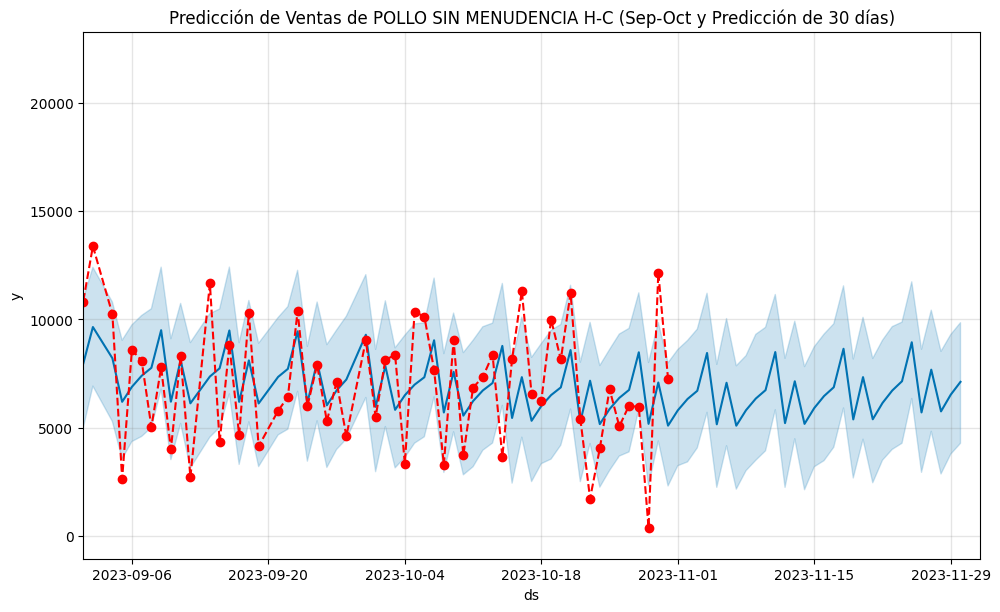

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxw9eqej/04dswc64.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxw9eqej/jf1w_pjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32015', 'data', 'file=/tmp/tmpyxw9eqej/04dswc64.json', 'init=/tmp/tmpyxw9eqej/jf1w_pjs.json', 'output', 'file=/tmp/tmpyxw9eqej/prophet_models12af6_9/prophet_model-20240302215114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
996  2023-11-01 5803.8489
997  2023-11-02 6328.3784
998  2023-11-03 6706.0904
999  2023-11-04 8452.3440
1000 2023-11-05 5158.0573
1001 2023-11-06 7077.3262
1002 2023-11-07 5095.7510
1003 2023-11-08 5811.9786
1004 2023-11-09 6347.2257
1005 2023-11-10 6736.2389
1006 2023-11-11 8494.4891
1007 2023-11-12 5212.9944
1008 2023-11-13 7145.9362
1009 2023-11-14 5178.9819
1010 2023-11-15 5910.8242
1011 2023-11-16 6462.7024
1012 2023-11-17 6869.3593
1013 2023-11-18 8646.2342
1014 2023-11-19 5384.2844
1015 2023-11-20 7337.6003
1016 2023-11-21 5391.7274
1017 2023-11-22 6145.2061
1018 2023-11-23 6719.0931
1019 2023-11-24 7147.9197
1020 2023-11-25 8946.8866
1021 2023-11-26 5706.6872
1022 2023-11-27 7681.1257
1023 2023-11-28 5755.4426
1024 2023-11-29 6527.8578
1025 2023-11-30 7119.0964
             ds NombreProducto        y
0    2021-01-02   PIERNA MUSLO 301.0240
1    2021-01-03   PIERNA MUSLO 499.9280
2    2021-

21:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


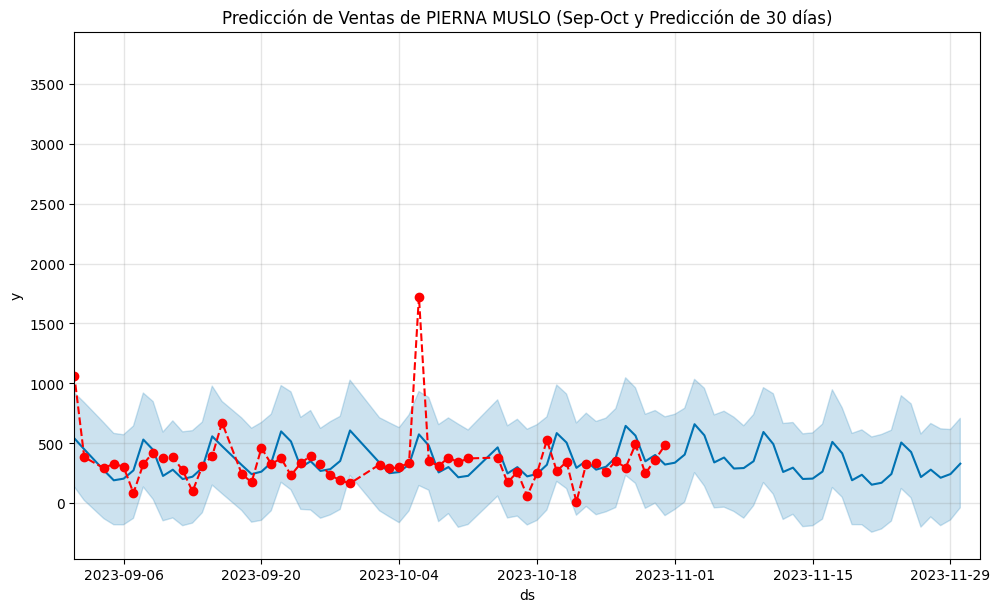

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxw9eqej/frj9zfui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxw9eqej/2aorig1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7409', 'data', 'file=/tmp/tmpyxw9eqej/frj9zfui.json', 'init=/tmp/tmpyxw9eqej/2aorig1k.json', 'output', 'file=/tmp/tmpyxw9eqej/prophet_modelbxxdxetv/prophet_model-20240302215115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para PIERNA MUSLO:
            ds     yhat
904 2023-11-01 336.8389
905 2023-11-02 404.7596
906 2023-11-03 658.3358
907 2023-11-04 565.6092
908 2023-11-05 339.3321
909 2023-11-06 380.0188
910 2023-11-07 288.3745
911 2023-11-08 292.2470
912 2023-11-09 349.5272
913 2023-11-10 593.5331
914 2023-11-11 492.5843
915 2023-11-12 259.6827
916 2023-11-13 295.5556
917 2023-11-14 201.0797
918 2023-11-15 204.2269
919 2023-11-16 262.9613
920 2023-11-17 510.6206
921 2023-11-18 415.4900
922 2023-11-19 190.4820
923 2023-11-20 236.1827
924 2023-11-21 153.2774
925 2023-11-22 169.5019
926 2023-11-23 242.5446
927 2023-11-24 505.4342
928 2023-11-25 426.1217
929 2023-11-26 217.1681
930 2023-11-27 278.7988
931 2023-11-28 211.3389
932 2023-11-29 242.1726
933 2023-11-30 328.6542
             ds NombreProducto        y
0    2021-01-02        PECHUGA 198.3520
1    2021-01-03        PECHUGA 279.1280
2    2021-01-04        PECHUGA 172.8680
3    2021-01-05        PECHUGA 513.8200
4   

21:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


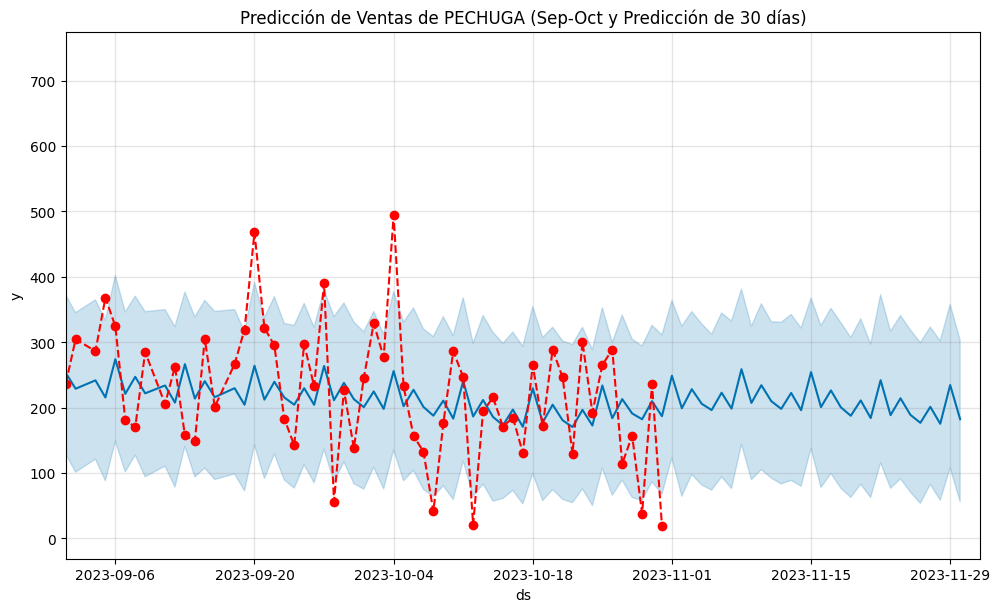

Predicción con todos los valores para PECHUGA:
            ds     yhat
924 2023-11-01 248.7801
925 2023-11-02 199.0455
926 2023-11-03 228.1851
927 2023-11-04 205.8731
928 2023-11-05 196.2633
929 2023-11-06 222.7979
930 2023-11-07 198.5008
931 2023-11-08 258.7238
932 2023-11-09 207.1566
933 2023-11-10 234.3012
934 2023-11-11 209.8838
935 2023-11-12 198.1123
936 2023-11-13 222.4836
937 2023-11-14 196.0754
938 2023-11-15 254.2907
939 2023-11-16 200.8669
940 2023-11-17 226.3487
941 2023-11-18 200.4985
942 2023-11-19 187.5534
943 2023-11-20 211.0318
944 2023-11-21 184.0242
945 2023-11-22 241.9382
946 2023-11-23 188.5069
947 2023-11-24 214.2626
948 2023-11-25 188.9474
949 2023-11-26 176.7709
950 2023-11-27 201.2179
951 2023-11-28 175.3403
952 2023-11-29 234.5032
953 2023-11-30 182.3946


In [44]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'

# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='red', marker='o', linestyle='dashed')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion sin 2020

In [45]:
# # Iterar sobre los productos en dfs_noviembre_sumados
# for product, product_df in dfs_noviembre_sumados.items():
#     # Crear un nombre único para la columna de predicciones de Prophet
#     col_name = f'P-V_PROPHET_{product}'

#     # Convertir la columna de fecha a tipo datetime
#     product_df['FechaMovimiento'] = pd.to_datetime(product_df.index)

#     # Fusionar el DataFrame de ventas con el DataFrame de predicciones
#     product_df = pd.merge(product_df, valores_prediccion[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

#     # Renombrar la columna yhat a Ventas_PROPHET
#     product_df.rename(columns={'yhat': col_name}, inplace=True)

#     # Opcional: Eliminar la columna adicional 'ds' si no la necesitas
#     product_df.drop(columns=['ds'], inplace=True)

#     # Actualizar el DataFrame en el diccionario
#     dfs_noviembre_sumados[product] = product_df

In [46]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.

In [47]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
 FechaMovimiento                                        
 2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
 2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
 2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
 2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
 2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
 2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
 2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
 2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
 2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
 2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
 2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
 2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
 2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
 2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
 2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
 20

# LSTM


In [48]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [49]:
print(dfs_de_productos_sumados_lstm['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_lstm)

NombreProducto     object
MontoBase         float64
DayOW               int64
Month               int64
Year                int64
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  DayOW  Month  Year
FechaMovimiento                                                         
2021-01-02       POLLO SIN MENUDENCIA H-C 10510.9000      5      1  2021
2021-01-03       POLLO SIN MENUDENCIA H-C  4100.4080      6      1  2021
2021-01-04       POLLO SIN MENUDENCIA H-C  4341.8650      0      1  2021
2021-01-05       POLLO SIN MENUDENCIA H-C  4555.7320      1      1  2021
2021-01-06       POLLO SIN MENUDENCIA H-C  6008.0340      2      1  2021
...                                   ...        ...    ...    ...   ...
2023-10-27       POLLO SIN MENUDENCIA H-C  6026.4036      4     10  2023
2023-10-28       POLLO SIN MENUDENCIA H-C  5949.4542      5     10  2023
2023-10-29       POLLO SIN MENUDENCIA H-C   374.6544      6     10  2023
2023-10-30       POLLO S

In [50]:
# Función para crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])


## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Epoch 1/50
25/25 - 3s - loss: 0.0589 - 3s/epoch - 116ms/step
Epoch 2/50
25/25 - 0s - loss: 0.0129 - 326ms/epoch - 13ms/step
Epoch 3/50
25/25 - 0s - loss: 0.0125 - 310ms/epoch - 12ms/step
Epoch 4/50
25/25 - 0s - loss: 0.0125 - 314ms/epoch - 13ms/step
Epoch 5/50
25/25 - 0s - loss: 0.0126 - 318ms/epoch - 13ms/step
Epoch 6/50
25/25 - 0s - loss: 0.0125 - 339ms/epoch - 14ms/step
Epoch 7/50
25/25 - 0s - loss: 0.0125 - 311ms/epoch - 12ms/step
Epoch 8/50
25/25 - 0s - loss: 0.0125 - 332ms/epoch - 13ms/step
Epoch 9/50
25/25 - 0s - loss: 0.0124 - 313ms/epoch - 13ms/step
Epoch 10/50
25/25 - 0s - loss: 0.0128 - 317ms/epoch - 13ms/step
Epoch 11/50
25/25 - 0s - loss: 0.0128 - 320ms/epoch - 13ms/step
Epoch 12/50
25/25 - 0s - loss: 0.0124 - 321ms/epoch - 13ms/step
Epoch 13/50
25/25 - 0s - loss: 0.0128 - 312ms/epoch - 12ms/step
Epoch 14/50
25/25 - 0s - loss: 0.0126 - 319ms/epoch - 13ms/step
Epoch 15/50
25/25 - 0s - loss: 0.0125 - 331ms/epoch - 13ms/step
Epoch 16/50
25/25 - 0s - loss: 0.0125 - 308ms/epoch

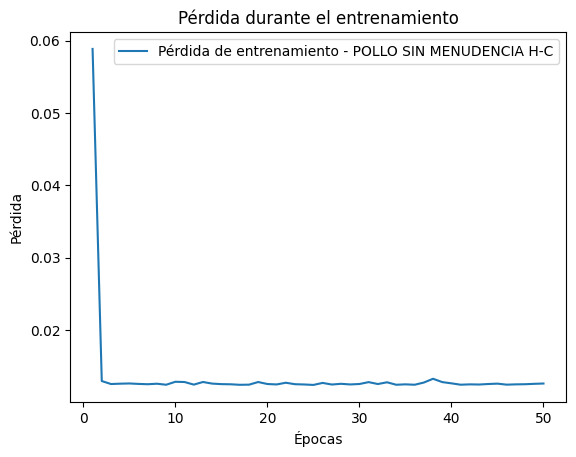

7/7 [==============================] - 0s 5ms/step


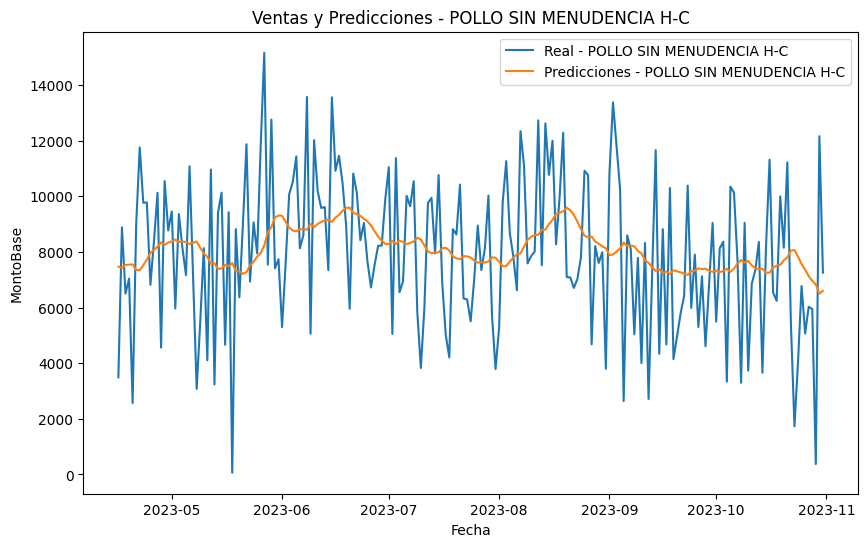

Dimensiones de fechas: (195,)
Dimensiones de predicciones: (194, 1)
La longitud de X_test es: 194 y la longitud de y_test es: 194
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 23ms/step
                 P-V_LSTM_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                   
2023-11-01                                       0
2023-11-02                                       0
2023-11-03                                       0
2023-11-04                                       0
2023-11-05                                       0
2023-11-06                                       0
2023-11-07                                       0
2023-11-08                                       0
2023-11-09                                       0
2023-11-10                                       0
2023-11-11                                       0
2023-11-12                                       0
2023-11-13                                       0
2023-11-14          

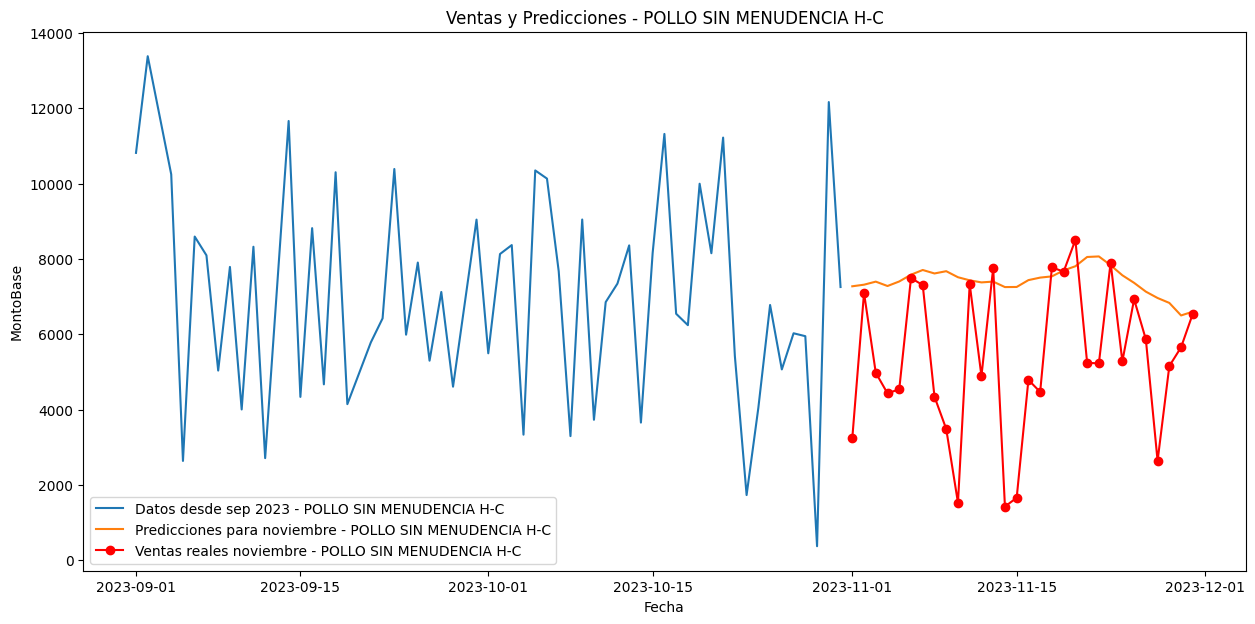

Epoch 1/50
22/22 - 3s - loss: 0.0104 - 3s/epoch - 132ms/step
Epoch 2/50
22/22 - 0s - loss: 0.0084 - 421ms/epoch - 19ms/step
Epoch 3/50
22/22 - 0s - loss: 0.0084 - 415ms/epoch - 19ms/step
Epoch 4/50
22/22 - 0s - loss: 0.0083 - 413ms/epoch - 19ms/step
Epoch 5/50
22/22 - 0s - loss: 0.0083 - 432ms/epoch - 20ms/step
Epoch 6/50
22/22 - 0s - loss: 0.0083 - 273ms/epoch - 12ms/step
Epoch 7/50
22/22 - 0s - loss: 0.0083 - 276ms/epoch - 13ms/step
Epoch 8/50
22/22 - 0s - loss: 0.0083 - 292ms/epoch - 13ms/step
Epoch 9/50
22/22 - 0s - loss: 0.0084 - 281ms/epoch - 13ms/step
Epoch 10/50
22/22 - 0s - loss: 0.0084 - 268ms/epoch - 12ms/step
Epoch 11/50
22/22 - 0s - loss: 0.0083 - 269ms/epoch - 12ms/step
Epoch 12/50
22/22 - 0s - loss: 0.0083 - 280ms/epoch - 13ms/step
Epoch 13/50
22/22 - 0s - loss: 0.0083 - 269ms/epoch - 12ms/step
Epoch 14/50
22/22 - 0s - loss: 0.0083 - 270ms/epoch - 12ms/step
Epoch 15/50
22/22 - 0s - loss: 0.0084 - 279ms/epoch - 13ms/step
Epoch 16/50
22/22 - 0s - loss: 0.0083 - 270ms/epoch

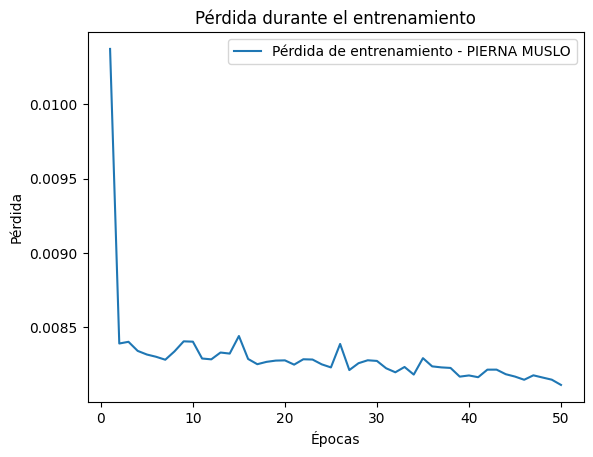

6/6 [==============================] - 1s 6ms/step


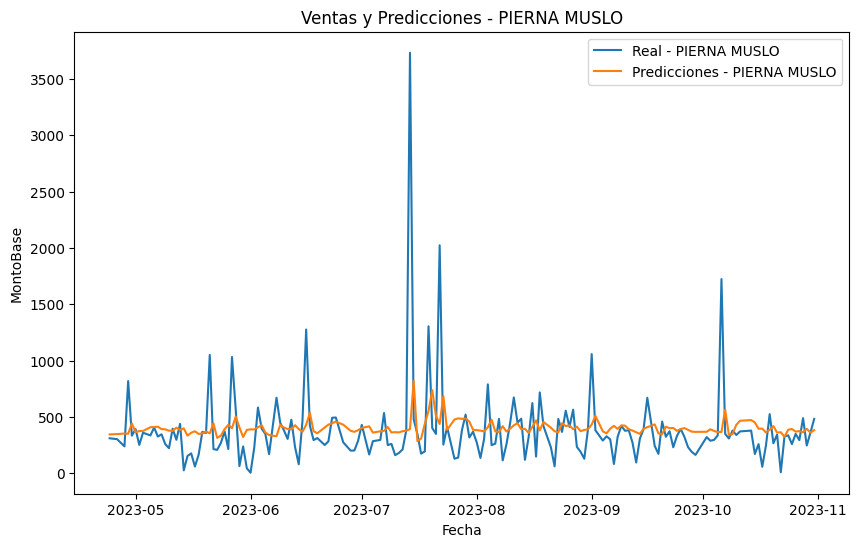

Dimensiones de fechas: (176,)
Dimensiones de predicciones: (175, 1)
La longitud de X_test es: 175 y la longitud de y_test es: 175
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 23ms/step
                 P-V_LSTM_PIERNA MUSLO
FechaMovimiento                       
2023-11-01                           0
2023-11-02                           0
2023-11-03                           0
2023-11-04                           0
2023-11-05                           0
2023-11-06                           0
2023-11-07                           0
2023-11-08                           0
2023-11-09                           0
2023-11-10                           0
2023-11-11                           0
2023-11-12                           0
2023-11-13                           0
2023-11-14                           0
2023-11-15                           0
2023-11-16                           0
2023-11-17                           0
2023-11-18                           0
2023-

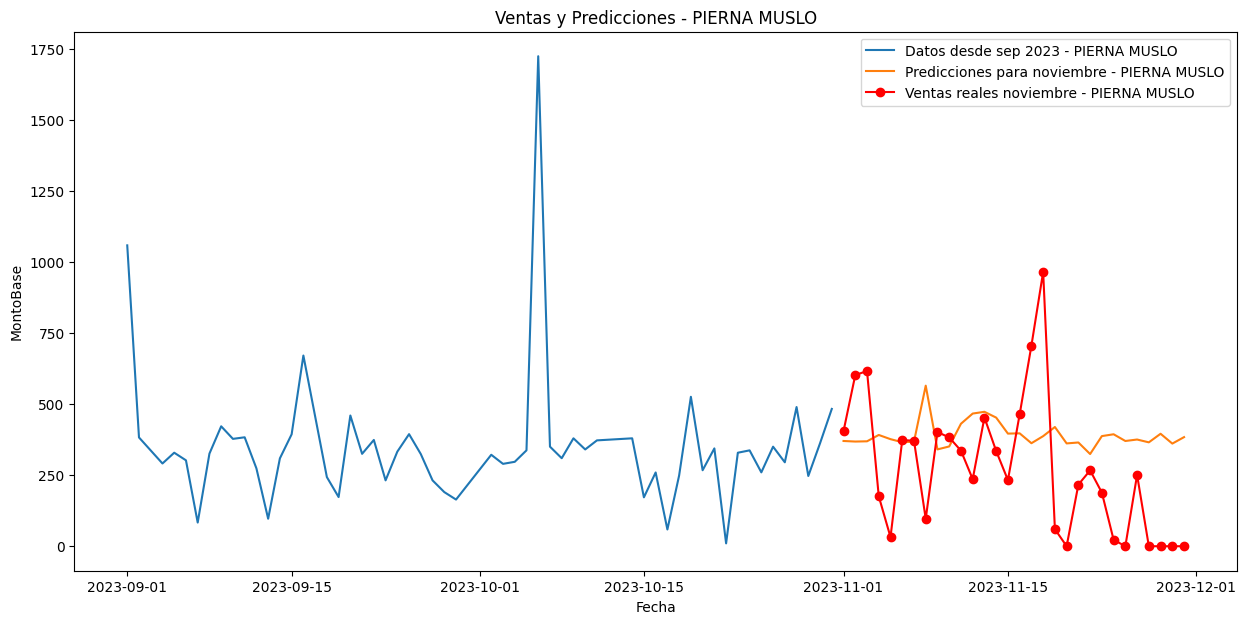

Epoch 1/50
23/23 - 2s - loss: 0.0419 - 2s/epoch - 95ms/step
Epoch 2/50
23/23 - 0s - loss: 0.0179 - 294ms/epoch - 13ms/step
Epoch 3/50
23/23 - 0s - loss: 0.0177 - 292ms/epoch - 13ms/step
Epoch 4/50
23/23 - 0s - loss: 0.0175 - 306ms/epoch - 13ms/step
Epoch 5/50
23/23 - 0s - loss: 0.0175 - 284ms/epoch - 12ms/step
Epoch 6/50
23/23 - 0s - loss: 0.0177 - 289ms/epoch - 13ms/step
Epoch 7/50
23/23 - 0s - loss: 0.0175 - 295ms/epoch - 13ms/step
Epoch 8/50
23/23 - 0s - loss: 0.0175 - 303ms/epoch - 13ms/step
Epoch 9/50
23/23 - 0s - loss: 0.0175 - 285ms/epoch - 12ms/step
Epoch 10/50
23/23 - 0s - loss: 0.0174 - 292ms/epoch - 13ms/step
Epoch 11/50
23/23 - 0s - loss: 0.0176 - 305ms/epoch - 13ms/step
Epoch 12/50
23/23 - 0s - loss: 0.0176 - 290ms/epoch - 13ms/step
Epoch 13/50
23/23 - 0s - loss: 0.0175 - 290ms/epoch - 13ms/step
Epoch 14/50
23/23 - 0s - loss: 0.0177 - 294ms/epoch - 13ms/step
Epoch 15/50
23/23 - 0s - loss: 0.0174 - 301ms/epoch - 13ms/step
Epoch 16/50
23/23 - 0s - loss: 0.0176 - 288ms/epoch 

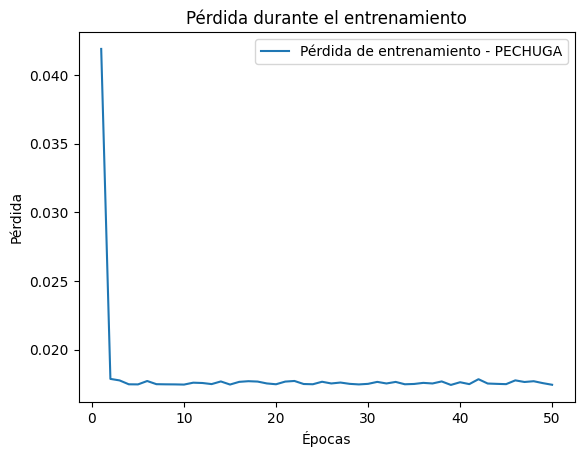

6/6 [==============================] - 1s 7ms/step


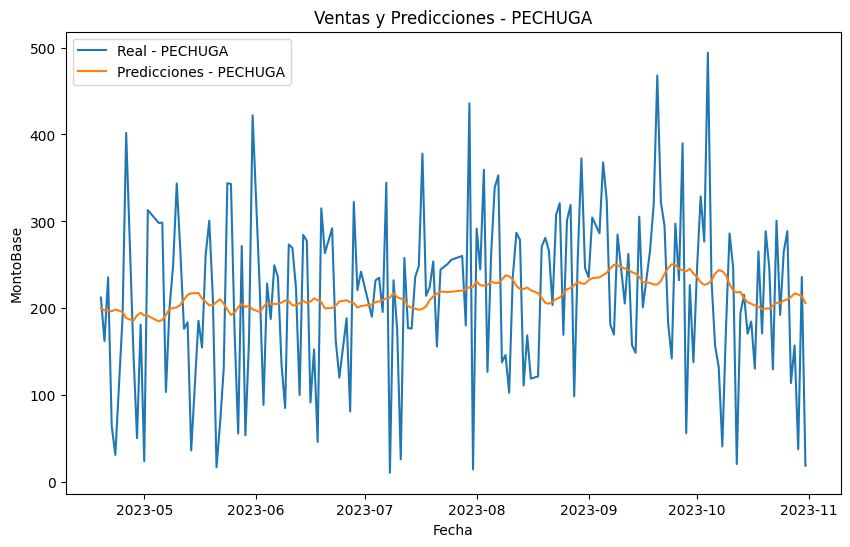

Dimensiones de fechas: (180,)
Dimensiones de predicciones: (179, 1)
La longitud de X_test es: 179 y la longitud de y_test es: 179
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 49ms/step
                 P-V_LSTM_PECHUGA
FechaMovimiento                  
2023-11-01                      0
2023-11-02                      0
2023-11-03                      0
2023-11-04                      0
2023-11-05                      0
2023-11-06                      0
2023-11-07                      0
2023-11-08                      0
2023-11-09                      0
2023-11-10                      0
2023-11-11                      0
2023-11-12                      0
2023-11-13                      0
2023-11-14                      0
2023-11-15                      0
2023-11-16                      0
2023-11-17                      0
2023-11-18                      0
2023-11-19                      0
2023-11-20                      0
2023-11-21                      0
202

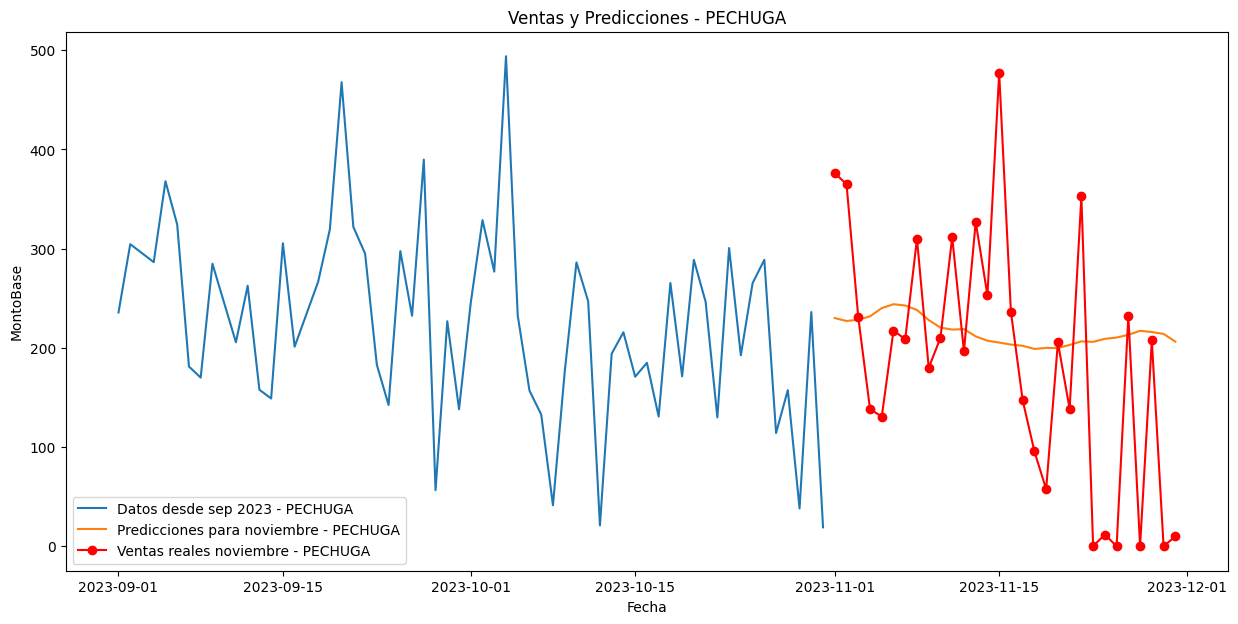

In [51]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
# predicciones_df_lstm = pd.DataFrame()
# predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre
# predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    product_df_lstm['MontoBase_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    X, y = create_sequences(product_df_lstm['MontoBase_scaler'].values, seq_length)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    # Visualizar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(product_df_lstm.index[train_size+seq_length:], product_df_lstm['MontoBase'].values[train_size+seq_length:], label='Real - ' + product)
    plt.plot(product_df_lstm.index[train_size+seq_length:], predictions, label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_days = product_df_lstm.tail(60)  # Últimos 30 días
    input_data = last_days['MontoBase'].values
    input_data = scaler.transform(input_data.reshape(-1, 1))

    print("Dimensiones de fechas:", product_df_lstm.index[train_size+seq_length-1:].shape)
    print("Dimensiones de predicciones:", predictions.shape)
    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')

    input_data, _ = create_sequences(input_data, seq_length)

    # Imprimir la forma de input_data para depuración
    print("Forma de input_data:", input_data.shape)

    # Hacer predicciones para el futuro
    predictions_future = model.predict(input_data)
    #predictions_future_nov = model.predict(last_data)

    # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
    predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
    predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
    predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
    predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

    # Imprimir el DataFrame inicial para depuración
    print(predicciones_df_lstm)

    # Desnormalizar las predicciones
    predictions_future = scaler.inverse_transform(predictions_future)

    # Actualizar las predicciones reales en las fechas correspondientes
    predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

    # Imprimir el DataFrame actualizado para depuración
    print(predicciones_df_lstm)

    # Agregar la columna al DataFrame original
    dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

    # Visualizar los resultados
    plt.figure(figsize=(15, 7))
    # Datos de venta desde el 1ro de septiembre de 2023
    start_date = '2023-09-01'
    end_date = '2023-11-30'
    plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product)
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product)
    # Datos reales de noviembre
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

In [52]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float32
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA

## Evaluar LSTM




In [53]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 7873672.225862186
MAE is : 2131.291824791667
R2 is : -1.035288161049348 %
------------------------------
MRSE is : 2806.0064550642405
MAPE is : 74.20201570221981 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 75025.2566008798
MAE is : 225.4444049658203
R2 is : -0.32081825115857354 %
------------------------------
MRSE is : 273.90738690455174
MAPE is : 193.31960668868848 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 16243.507438044015
MAE is : 101.59489222656251
R2 is : -0.016260420238595197 %
------------------------------
MRSE is

# ARIMA

In [54]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [56]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [57]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 2021-01-02 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  996 non-null    object 
 1   MontoBase       996 non-null    float64
dtypes: float64(1), object(1)
memory usage: 23.3+ KB


Predicciones para POLLO SIN MENUDENCIA H-C:


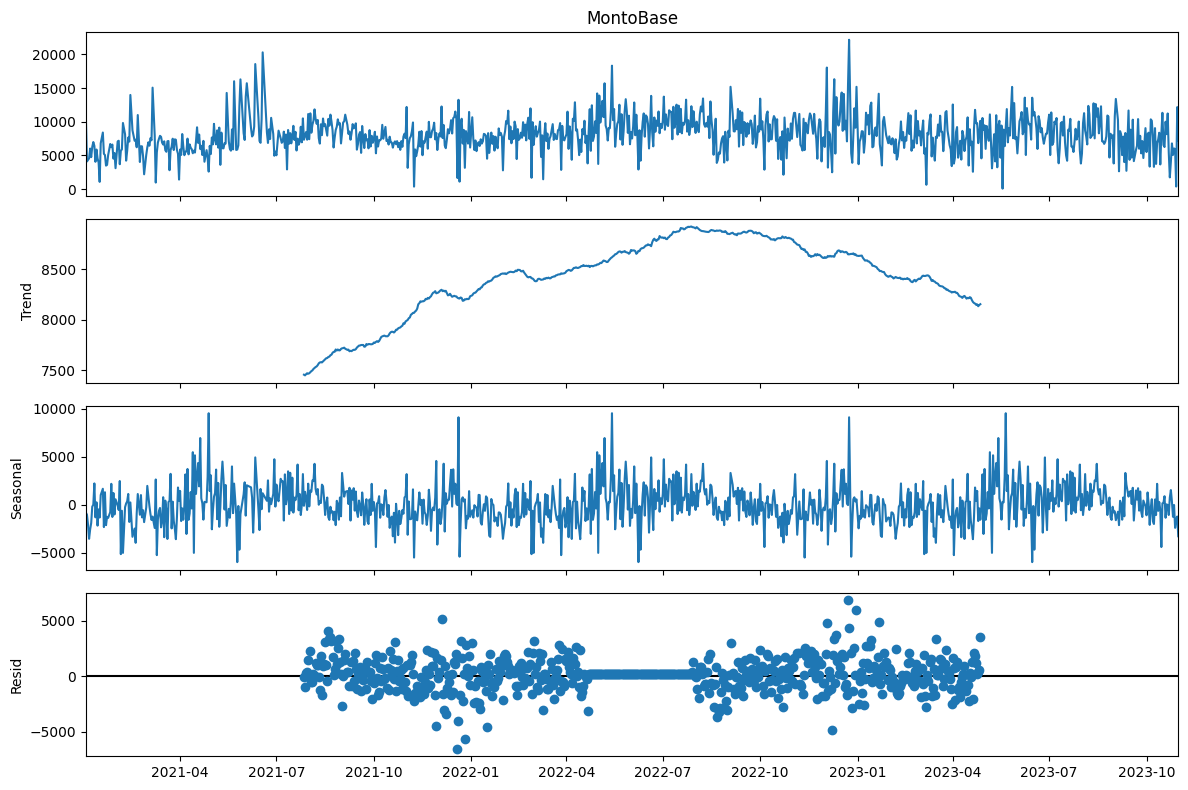

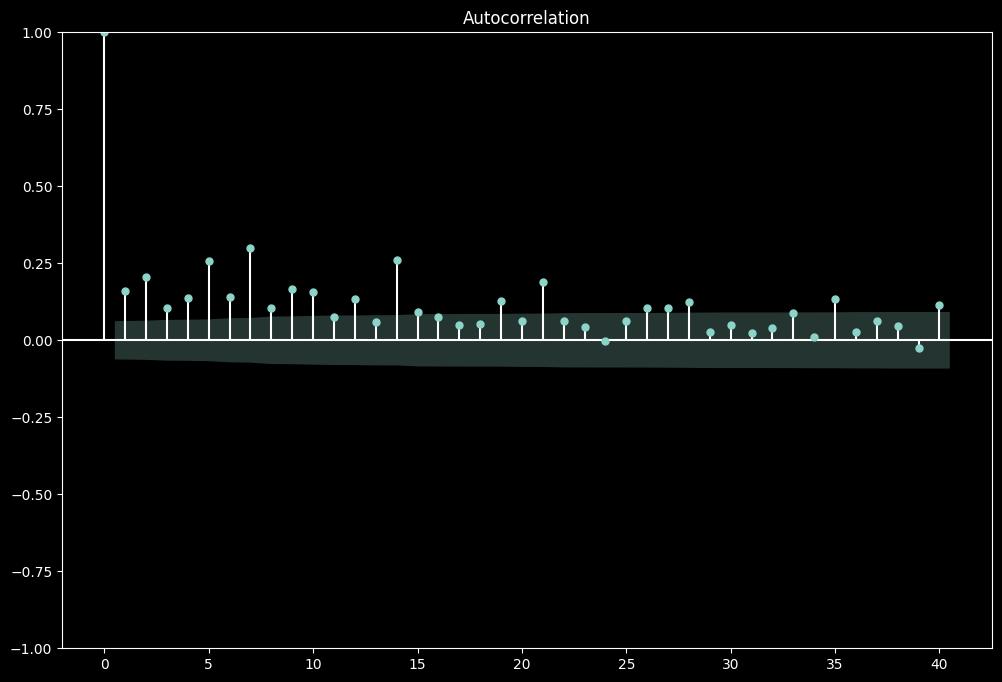

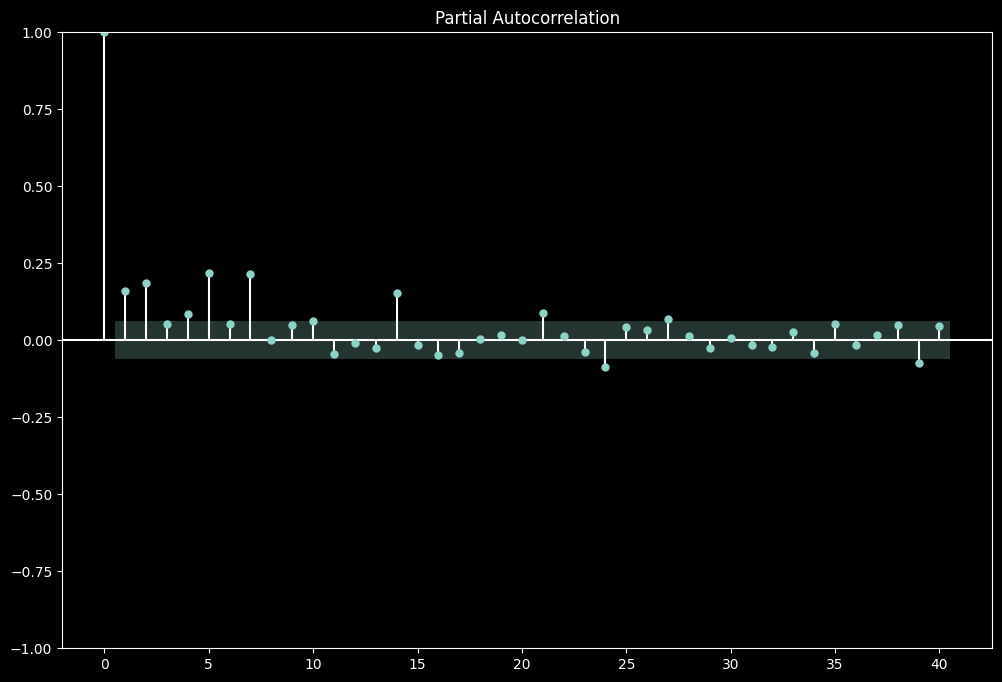

(965, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18767.322, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18364.754, Time=2.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18573.681, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18274.768, Time=5.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=39.63 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.08 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18503.530, Time=2.44 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=18198.903, Time=3.35 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=18301.037, Time=1.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=19.25 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=8.38 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=18137.577, Time=3.85 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=18229.621, Time=1.67 sec
 ARIMA(3,1,0)(2,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

el ultimo indice_valor de los datos reales es: 965,
se supone que deeria acabar 30 despues, pero la funcion indica: 994 

2023-10-01   6327.0854
2023-10-02   5148.4559
2023-10-03   5529.2586
2023-10-04   6418.3370
2023-10-05   6349.1311
2023-10-06   5967.2271
2023-10-07   4846.9877
2023-10-08   6465.0569
2023-10-09   3983.1942
2023-10-10   5881.7180
2023-10-11   5270.9419
2023-10-12   9141.6711
2023-10-13   5763.7255
2023-10-14   4363.0012
2023-10-15   4760.3759
2023-10-16   5374.2429
2023-10-17   4446.6850
2023-10-18   6508.2775
2023-10-19   3440.3163
2023-10-20   6115.9854
2023-10-21   2469.3360
2023-10-22   6900.8495
2023-10-23   3274.6631
2023-10-24   7539.1473
2023-10-25   4080.9481
2023-10-26   5303.8064
2023-10-27   3314.0547
2023-10-28   4385.7721
2023-10-29   4286.5841
2023-10-30   6296.6647
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
                 MontoBase  P-V_ARIMA_POLLO SIN

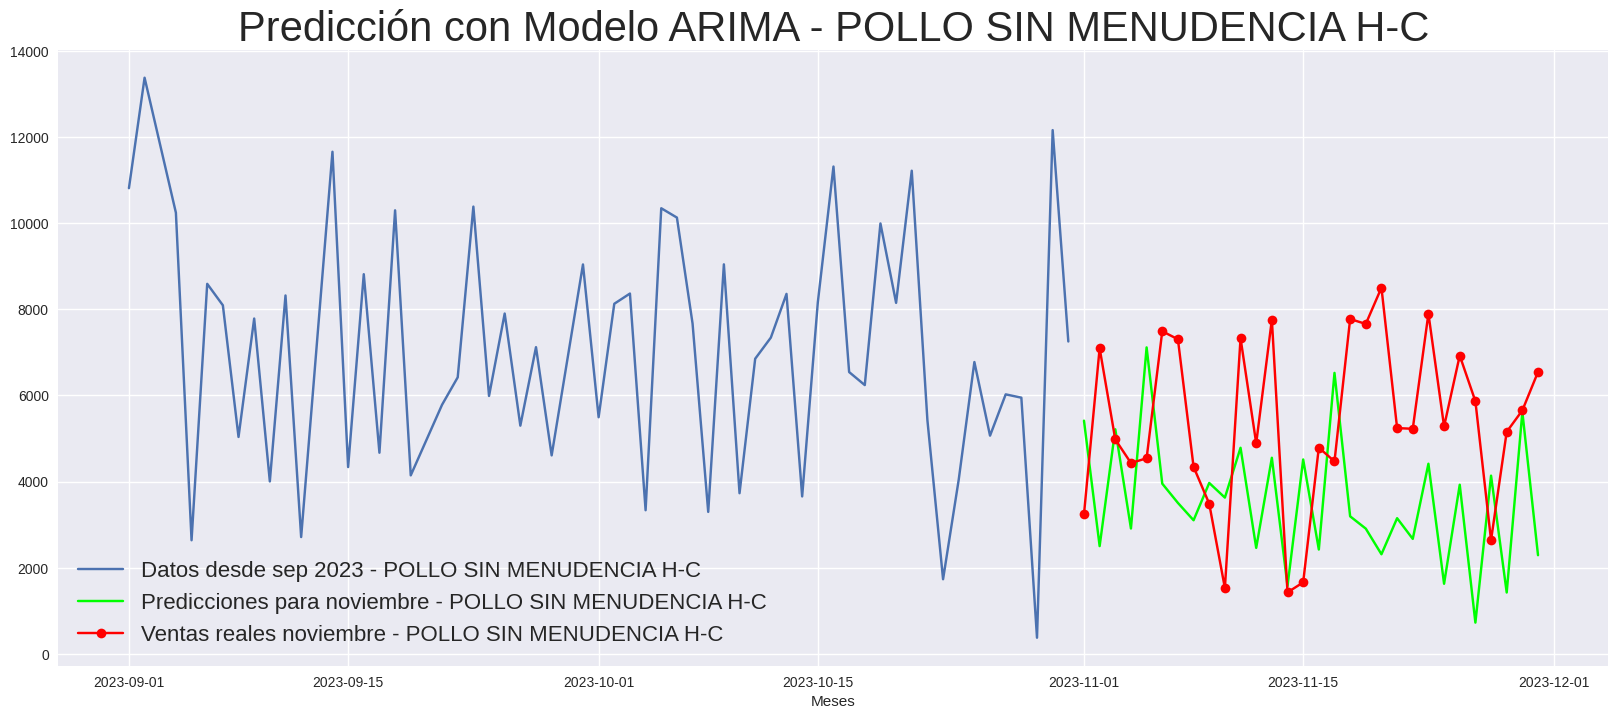

Predicciones para PIERNA MUSLO:


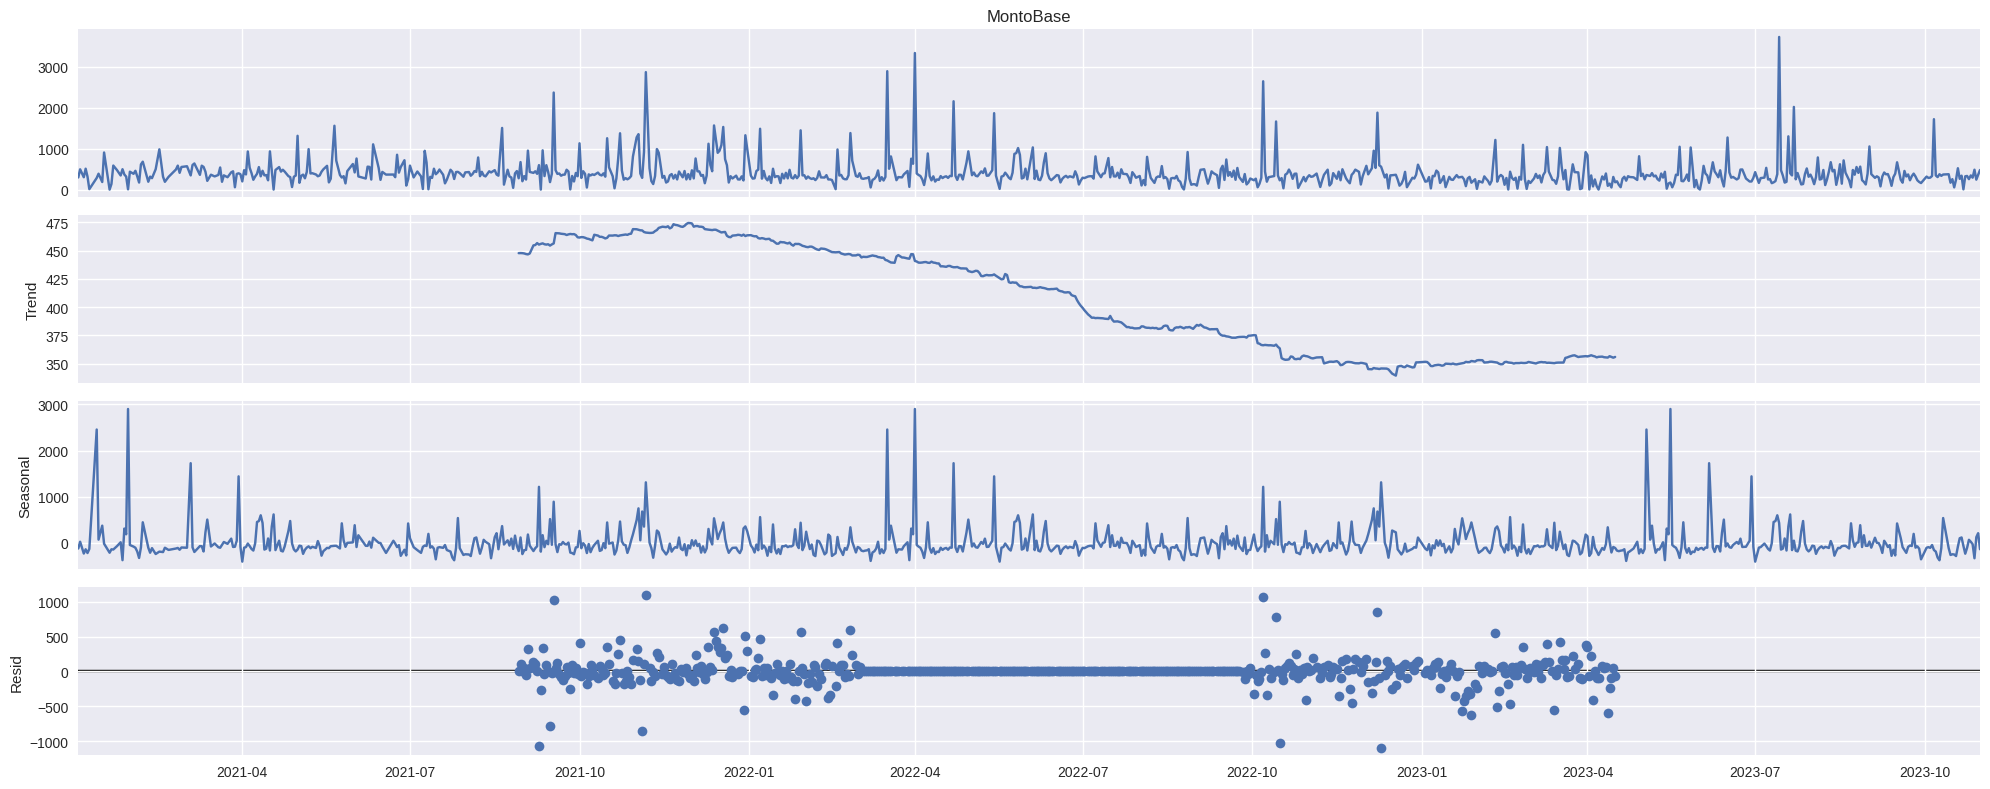

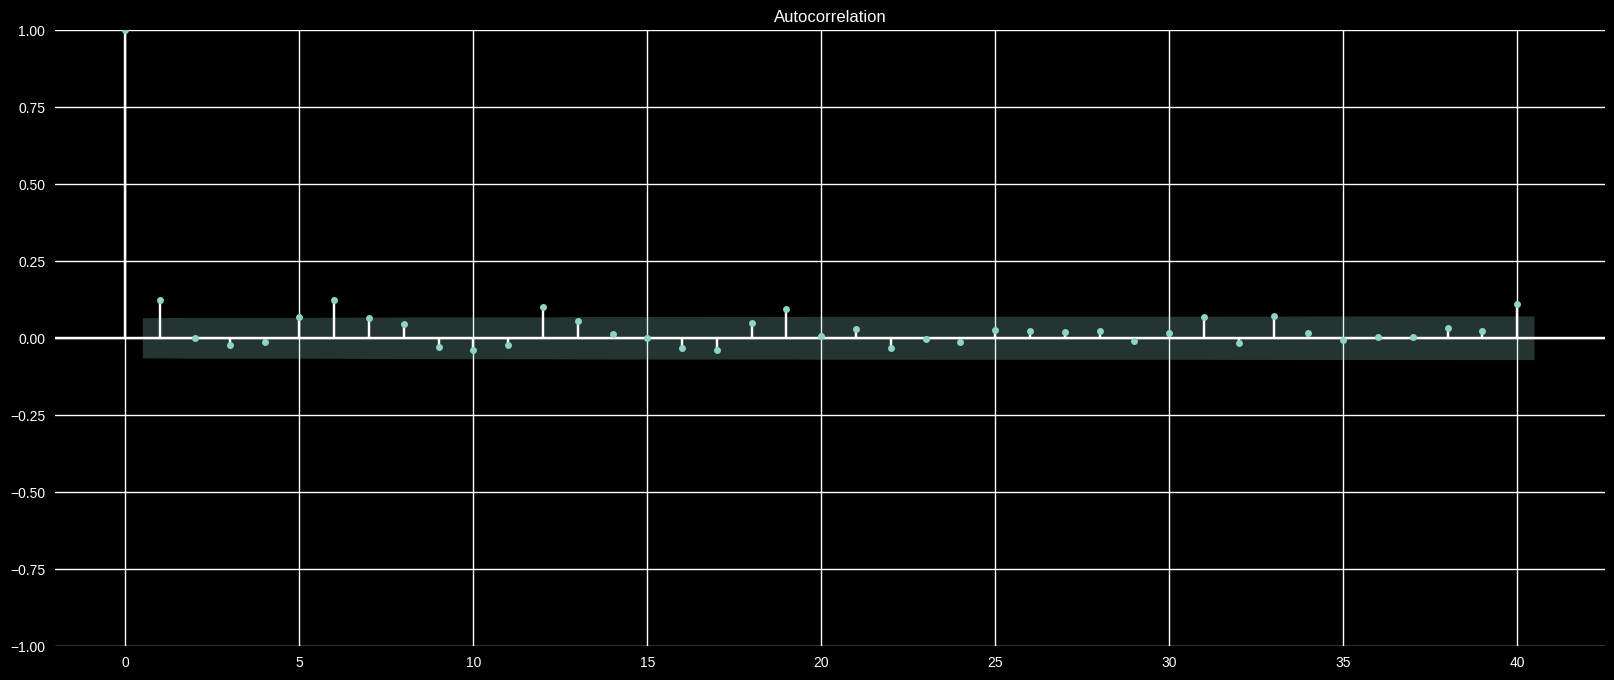

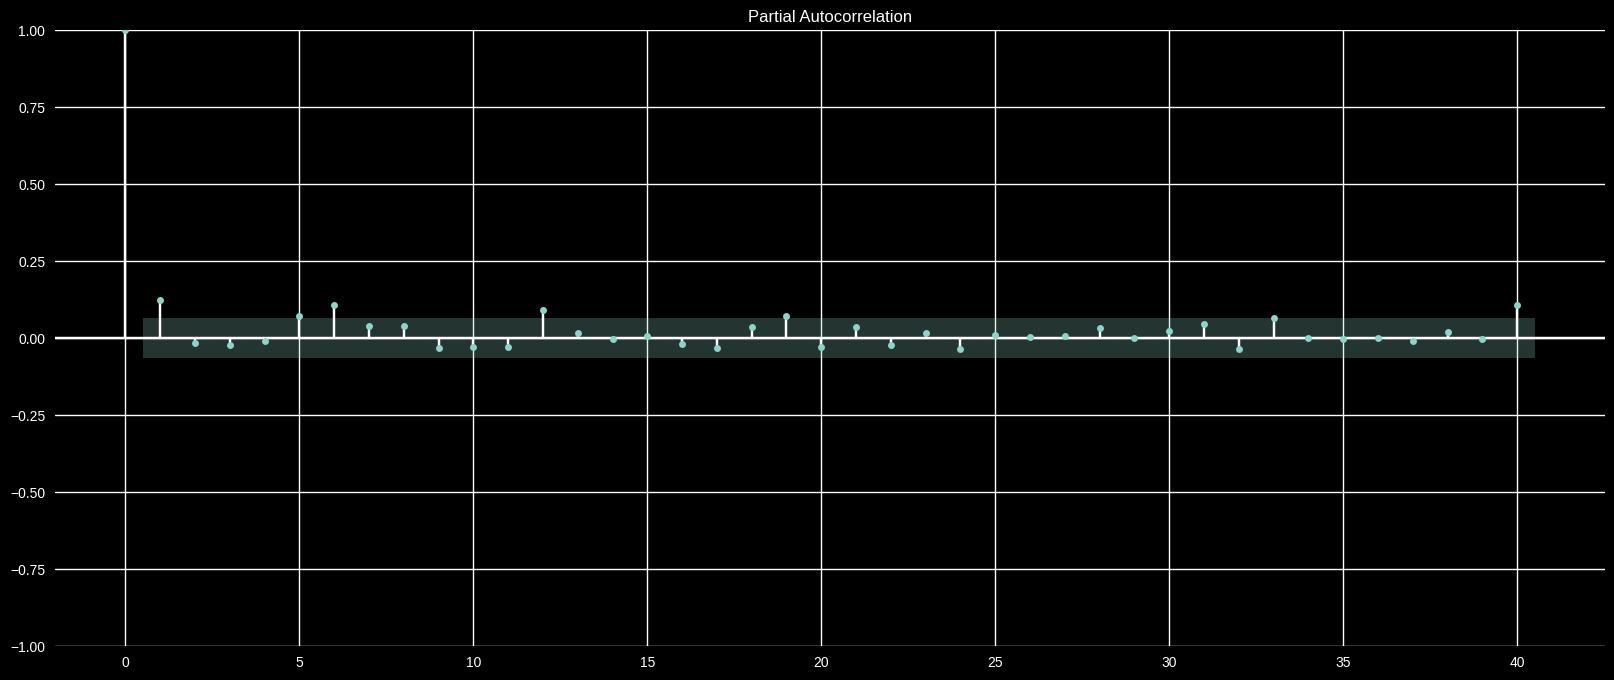

(873, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=13487.717, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13134.800, Time=1.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13307.109, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13051.184, Time=1.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13221.008, Time=0.56 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=12981.557, Time=2.78 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=13064.021, Time=1.24 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=13.46 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.95 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=12935.895, Time=3.94 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=13017.695, Time=1.86 sec
 ARIMA(3,1,0)(2,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 873,
se supone que deeria acabar 30 despues, pero la funcion indica: 902 

2023-09-27   519.0746
2023-09-28   325.4255
2023-09-29   352.6555
2023-09-30   344.0357
2023-10-01   299.0746
2023-10-02   383.9781
2023-10-03   345.4316
2023-10-04   439.9311
2023-10-05   264.1167
2023-10-06   302.1902
2023-10-07   281.7586
2023-10-08   283.2248
2023-10-09   633.1118
2023-10-10   357.3466
2023-10-11   412.3927
2023-10-12   311.8748
2023-10-13   265.9431
2023-10-14   304.5168
2023-10-15   330.7865
2023-10-16   414.1674
2023-10-17   289.5486
2023-10-18   333.8044
2023-10-19   305.9965
2023-10-20   231.4663
2023-10-21   497.2620
2023-10-22   358.0812
2023-10-23   477.1320
2023-10-24   295.7248
2023-10-25   242.2024
2023-10-26   372.1660
Freq: D, Name: ARIMA Predictions PIERNA MUSLO, dtype: float64

Ventas reales y predicciones ARIMA para PIERNA MUSLO:
                 MontoBase  P-V_ARIMA_PIERNA MUSLO
FechaMovimiento                                   

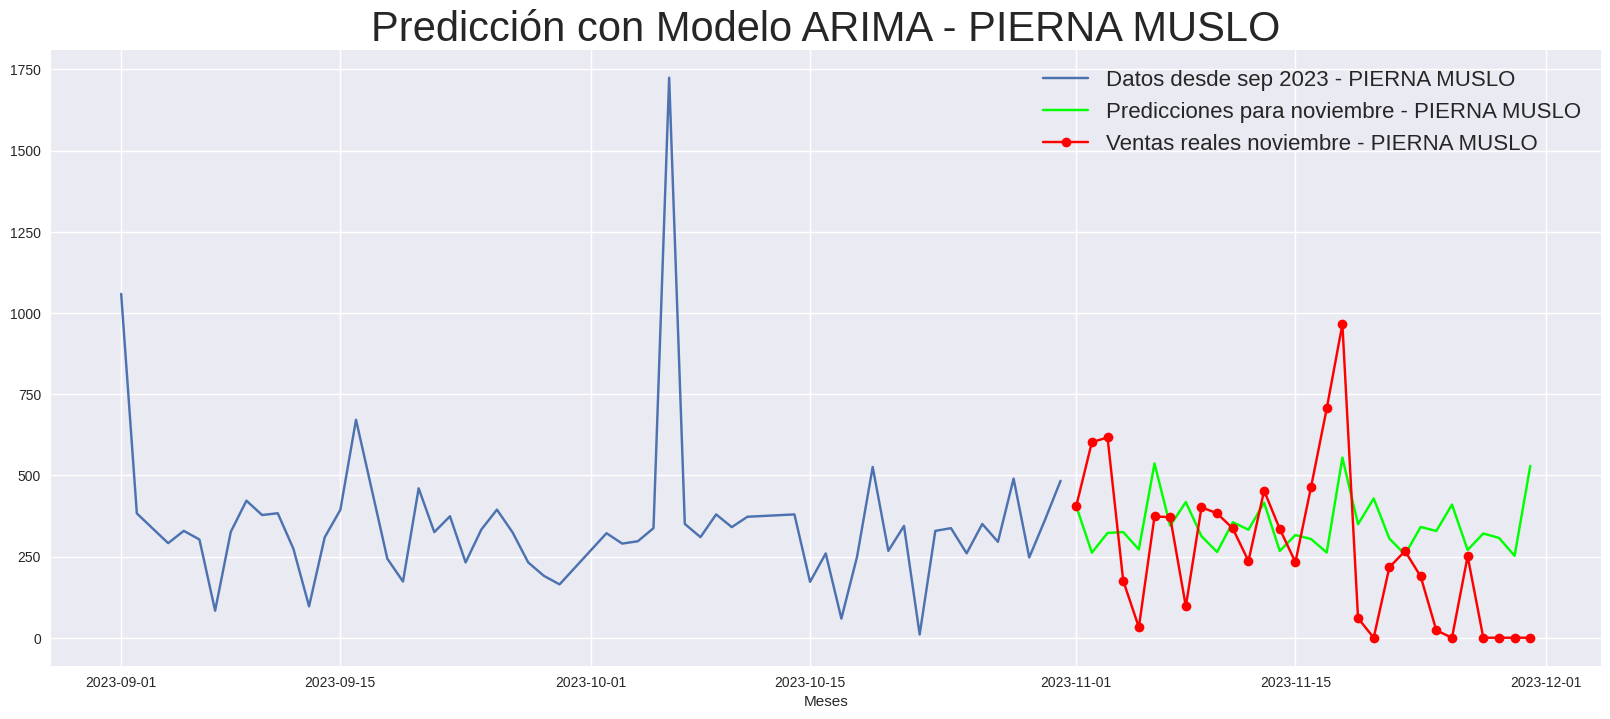

Predicciones para PECHUGA:


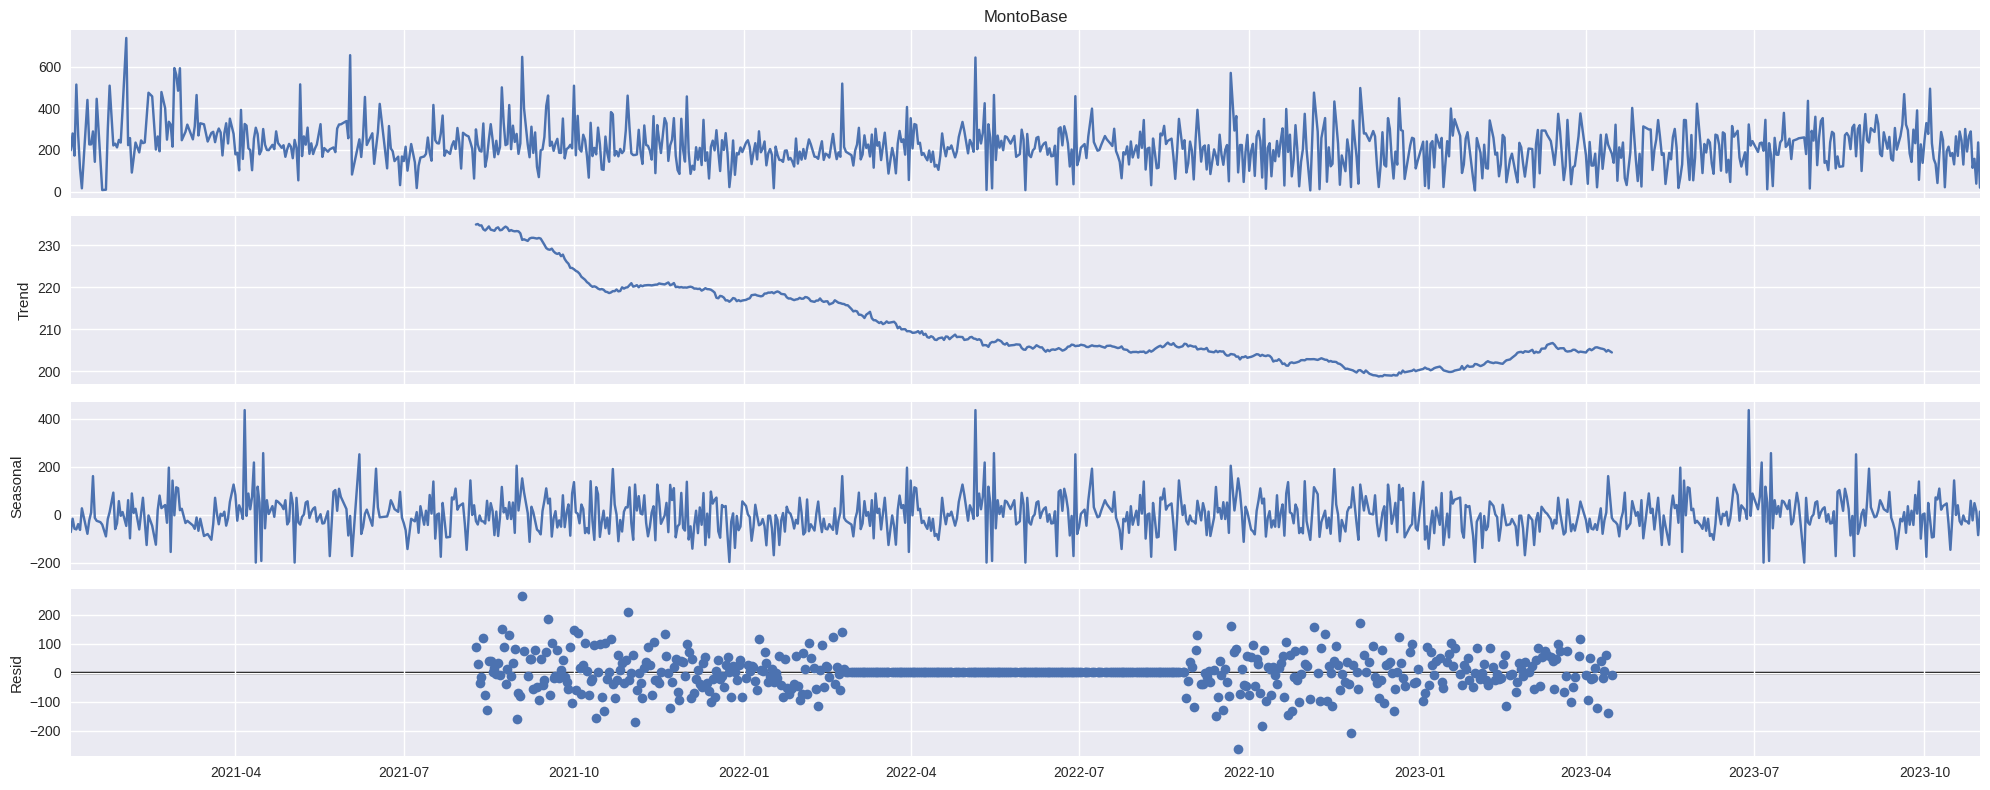

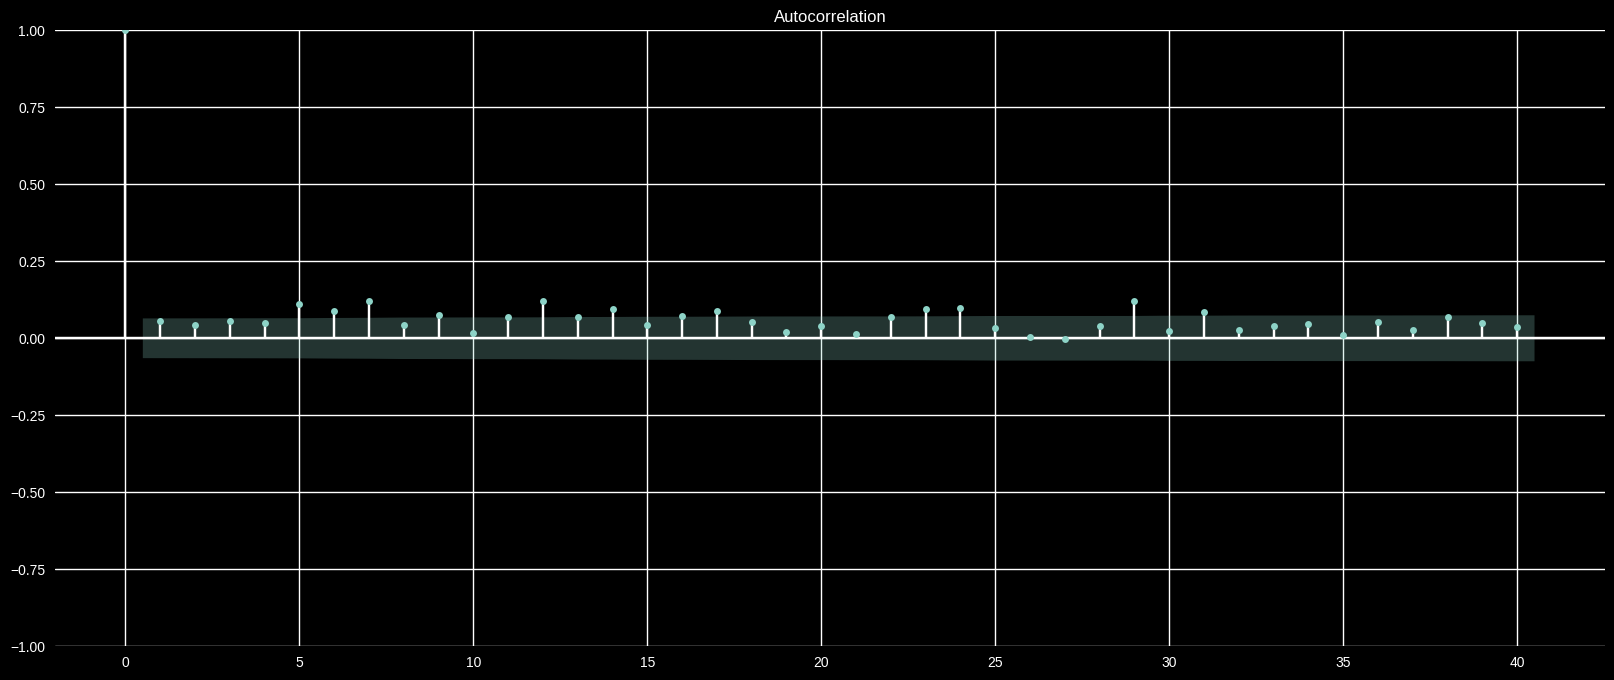

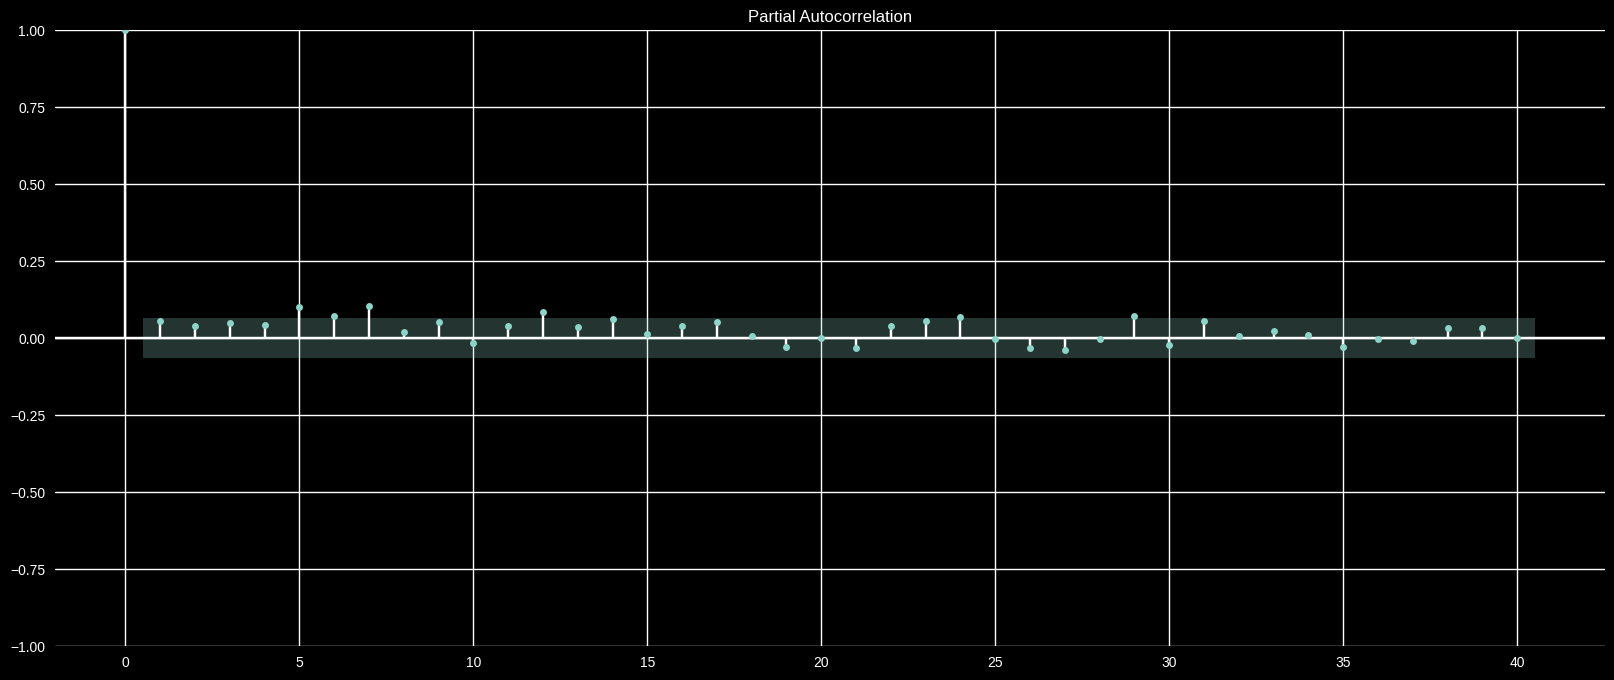

(893, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=11744.619, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11252.522, Time=0.74 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=11491.758, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11173.153, Time=1.86 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.37 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.61 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11409.301, Time=1.84 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11054.130, Time=2.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11127.018, Time=1.12 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=12.38 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.87 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=10996.574, Time=2.29 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=11072.748, Time=1.27 sec
 ARIMA(3,1,0)(2,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 893,
se supone que deeria acabar 30 despues, pero la funcion indica: 922 

2023-10-01   322.6506
2023-10-02   346.8496
2023-10-03   184.1216
2023-10-04   172.3310
2023-10-05   212.2456
2023-10-06    98.7023
2023-10-07   232.7357
2023-10-08   203.7877
2023-10-09   205.1749
2023-10-10   148.1951
2023-10-11   193.0407
2023-10-12   182.5833
2023-10-13   287.6236
2023-10-14   333.1064
2023-10-15   181.7961
2023-10-16   165.2061
2023-10-17   175.3057
2023-10-18    98.8282
2023-10-19   215.7425
2023-10-20   149.2981
2023-10-21   203.5382
2023-10-22   115.3351
2023-10-23   157.9518
2023-10-24   143.4210
2023-10-25   260.3861
2023-10-26   330.9315
2023-10-27   177.2667
2023-10-28   159.1519
2023-10-29   141.1264
2023-10-30    62.7176
Freq: D, Name: ARIMA Predictions PECHUGA, dtype: float64

Ventas reales y predicciones ARIMA para PECHUGA:
                 MontoBase  P-V_ARIMA_PECHUGA
FechaMovimiento                              
2023-11-01        3

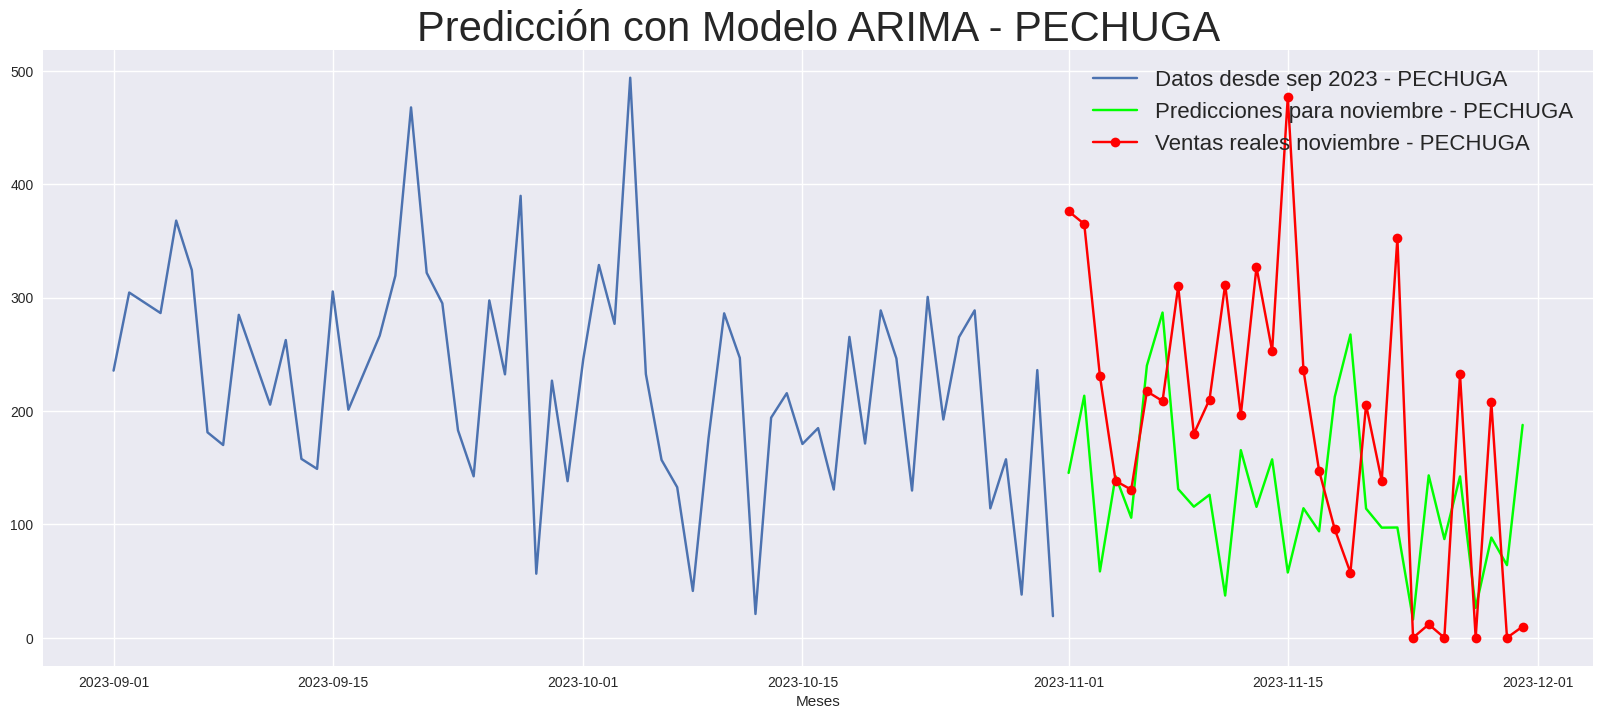

In [58]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    if len(product_df_arima) >= 730:
        # Aquí puedes poner el código para realizar la predicción con ARIMA
        print(f"Predicciones para {product}:")
        # Realizar descomposición estacional
        decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
        decomposition.plot();
        plt.show()
    else:
        print(f"No hay suficientes datos para graficar la descomposicion estacional del producto {product}.")
    # Visualizar ACF y PACF
    plt.style.use('dark_background')
    plot_acf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    plot_pacf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    # Dividir en orden cronológico, entrenando sin el mes de octubre
    train_size_arima = int(len(product_df_arima) - 31)
    train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

    print(train_arima.shape, test_arima.shape)

    # Identificar el modelo ARIMA automáticamente
    modelo_auto = auto_arima(train_arima['MontoBase'],
                              start_p=0, d=1, start_q=0,
                              max_p=5, max_d=2, max_q=5,
                              start_P=0, D=1, start_Q=0,
                              max_P=2, max_D=1, max_Q=2,
                              seasonal=True, m=12, trace=True,
                              error_action='ignore', suppress_warnings=True, stepwise=True,
                              random_state=20, n_fits=50
                              )
    print(modelo_auto.summary())

    # Configurar el modelo ARIMA
    arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
    arima_result = arima_model.fit()
    arima_models[product] = arima_result  # Guardar el modelo en el diccionario

    # Hacer predicciones con ARIMA
    arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
    # Crear un índice para las predicciones de noviembre
    november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
    arima_pred.index = november_index

    print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
    print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

    # Imprimir las predicciones para el mes de noviembre
    print(arima_pred)

    # Agregar las predicciones al DataFrame original
    if product in arima_models:
        # Hacer predicciones con ARIMA para el DataFrame actual
        arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

        # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
        arima_pred_full.index = dfs_noviembre_sumados[product].index

        # Agregar la columna de predicciones ARIMA al DataFrame actual
        dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

        # Imprimir el resultado
        print(f'\nVentas reales y predicciones ARIMA para {product}:')
        print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(20))
    else:
        print(f"No hay modelo ARIMA para {product}.")

    # Visualizar las predicciones y los datos reales
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20, 8)
    # Datos de venta desde el 1ro de septiembre de 2023
    # Convertir la cadena a un objeto datetime.date
    start_date = datetime.strptime('2023-09-01', '%Y-%m-%d').date()
    end_date = datetime.strptime('2023-11-30', '%Y-%m-%d').date()
    plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
    plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color="lime", label='Predicciones para noviembre - ' + product)
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
    plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
    plt.xlabel('Meses')
    plt.ylabel('')
    plt.legend(fontsize=16)
    plt.show()

In [59]:
#print(dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.

In [60]:
# ESTO ES PARA ELIMINAR LA COLUMA DE PREDICCION DE ARIMA QUE aparecia con 'nan'
# for product, product_df in dfs_noviembre_sumados.items():
#     product_df.drop(columns=[f'P-V_ARIMA_{product}'], inplace=True)
#     print(product_df)


## Evaluar ARIMA

In [61]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 9890682.16926003
MAE is : 2761.703554400893
R2 is : -1.5566708578083461 %
------------------------------
MRSE is : 3144.9454954354983
MAPE is : 54.39276058241156 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 65039.216387105145
MAE is : 205.93772468020262
R2 is : -0.14501419838040075 %
------------------------------
MRSE is : 255.02787374541072
MAPE is : 149.69727492532462 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 23242.460515447543
MAE is : 121.53788716003727
R2 is : -0.45414361897518596 %
------------------------------
MRSE 

Cómo interpretar las gráficas de residuos en el modelo ARIMA


# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-62-0bcf36039ac0>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


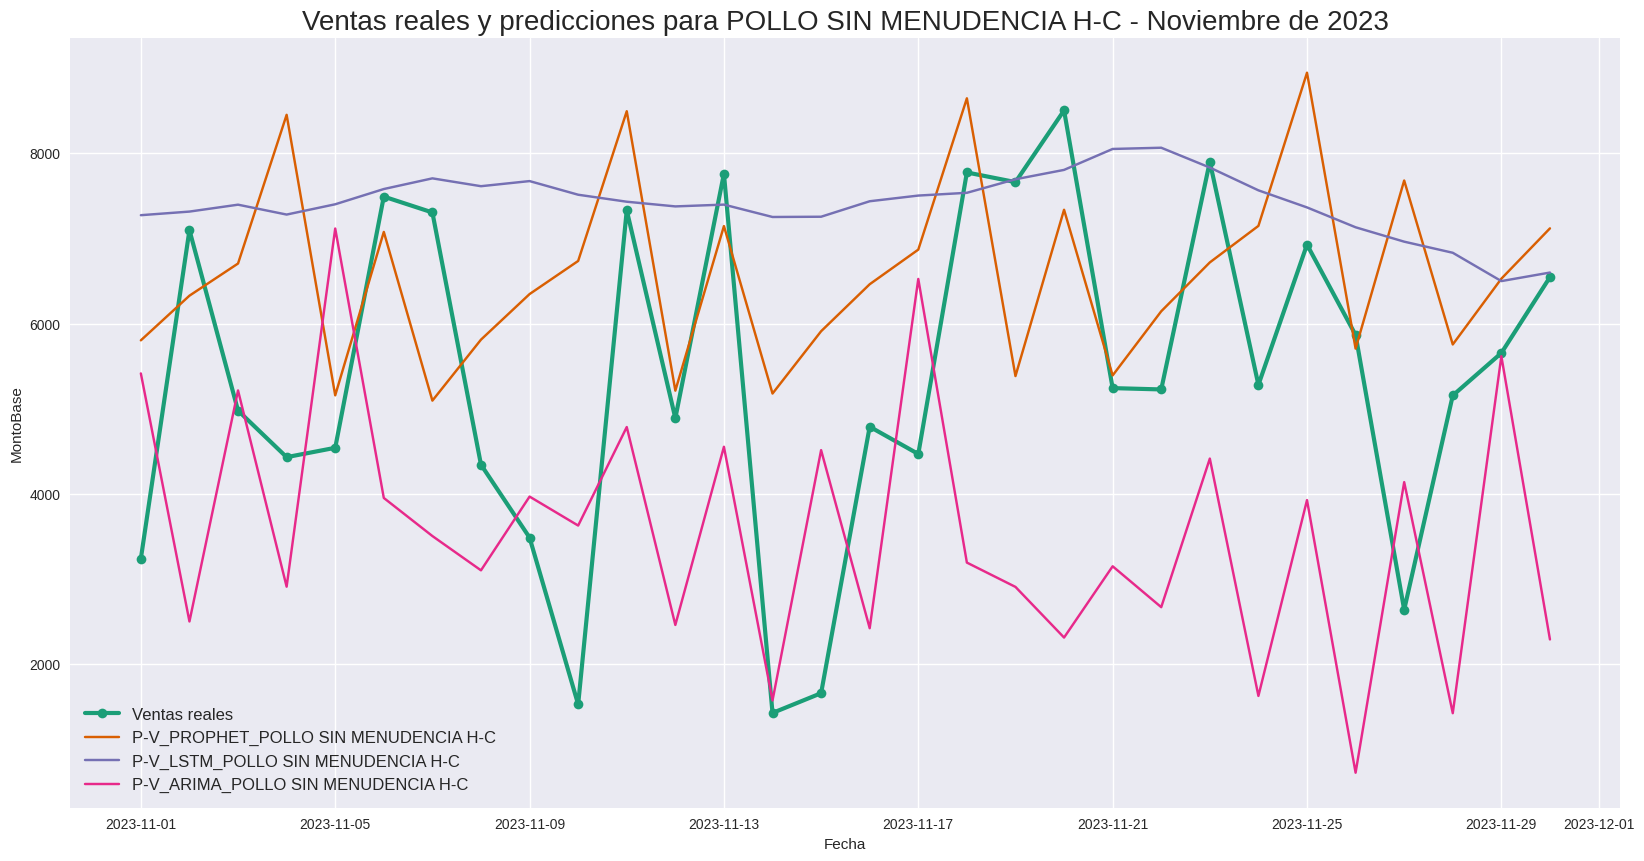

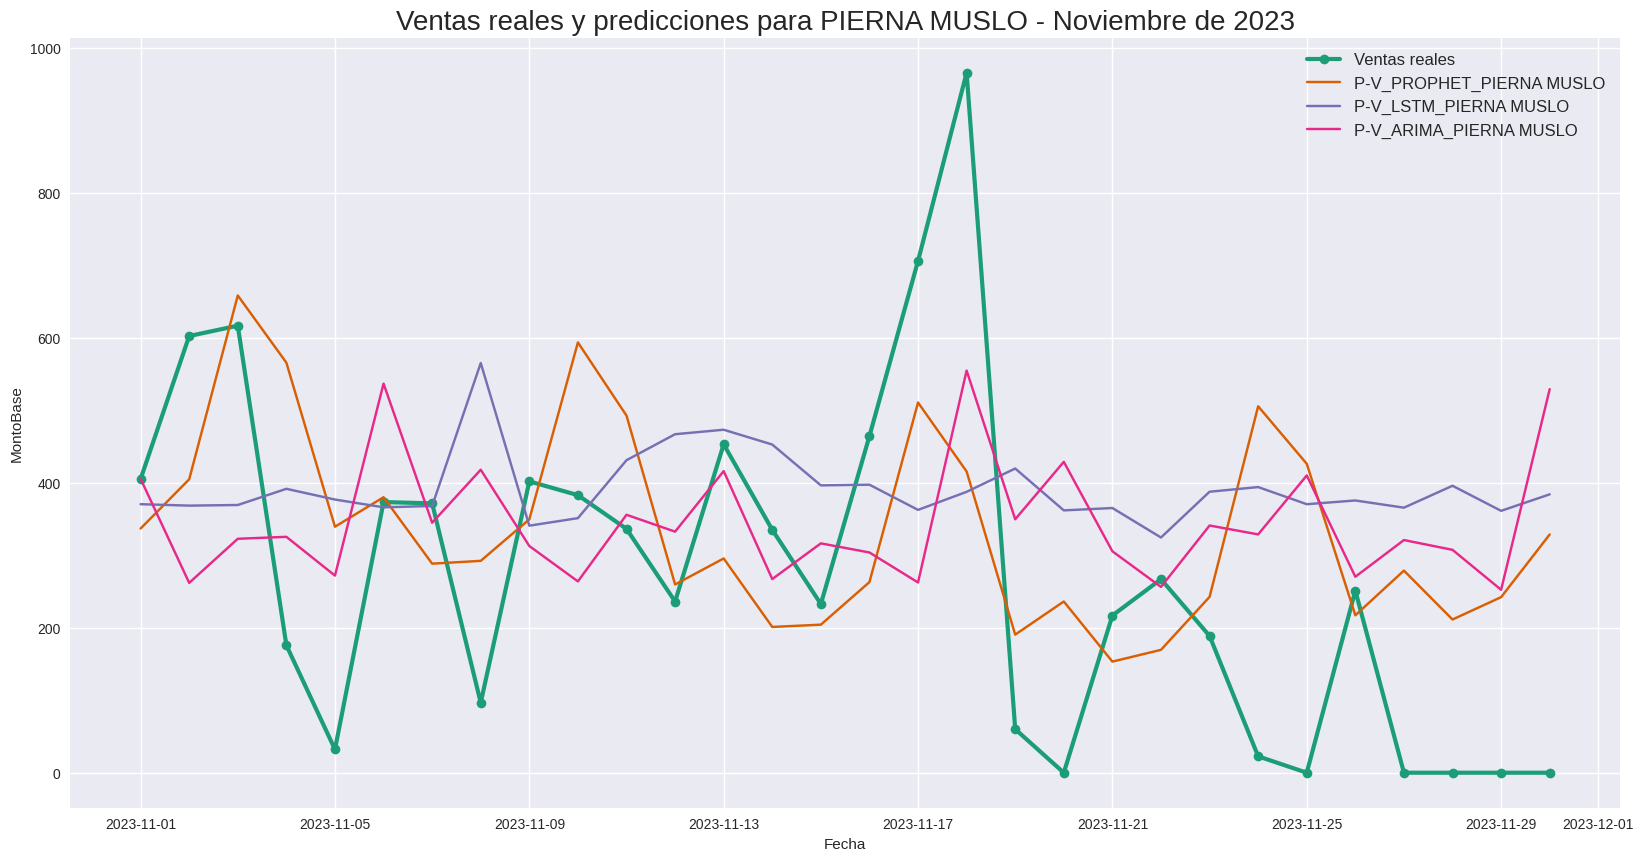

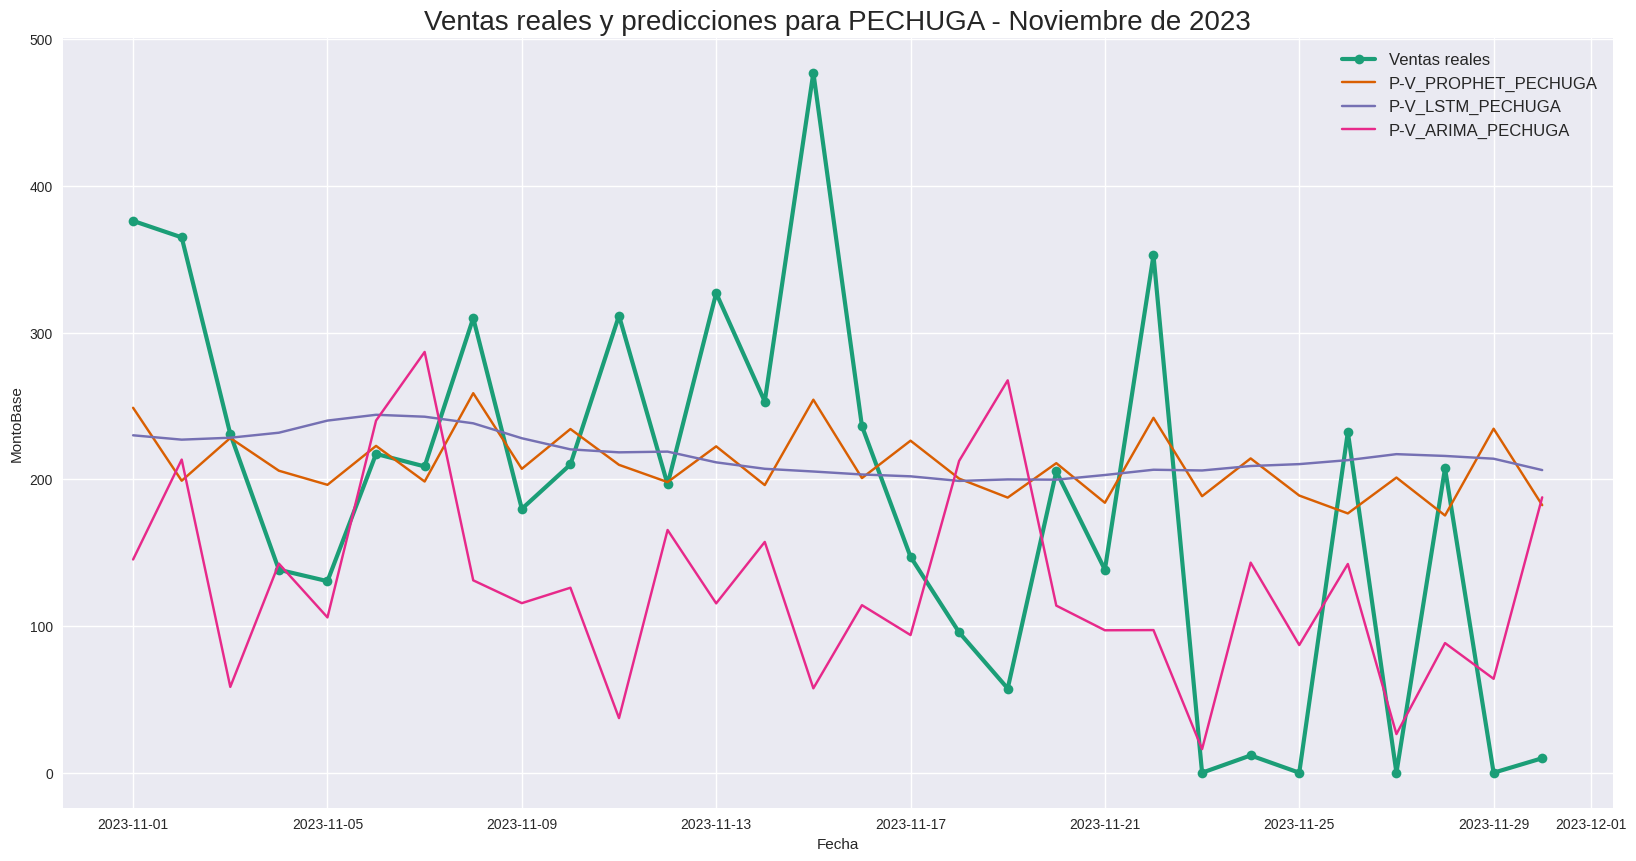

In [62]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales', marker='o', linewidth=3)

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data.index, product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [63]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO SIN MENUDENCIA H-C
Modelo: PROPHET
Evaluation metric results:  
MSE is : 5192538.354675164
MAE is : 1791.1622410751704
R2 is : -0.3422341616345057 %
------------------------------
MRSE is : 2278.7141888958263
MAPE is : 58.11170520981167 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 7873672.225862186
MAE is : 2131.291824791667
R2 is : -1.035288161049348 %
------------------------------
MRSE is : 2806.0064550642405
MAPE is : 74.20201570221981 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 9890682.16926003
MAE is : 2761.703554400893
R2 is : -1.5566708578083461 %
------------------------------
MRSE is : 3144.9454954354983
MAPE is : 54.39

In [64]:
for product, product_df in dfs_noviembre_sumados.items():

    print(product_df)


                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.